# Step Forward Cross Validation for Bioactivity Prediction

## Plots to show Model Performance across splits, folds and targets

In [13]:
import scipy.stats as stats
from itertools import combinations
import scikit_posthocs as sp
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [11]:
df = pd.read_csv('../benchmark/results/tables/results.csv')

In [12]:
sns.set_context("talk")
sns.set_style("whitegrid")
categorical_cols = ['target', 'split_type', 'fold_no', 'fingerprint', 'model']
metric_cols = [col for col in df.columns if col not in categorical_cols]

In [ ]:
for metric in metric_cols:
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))

    # ------------------------------
    # Plot 1: Effect of Fingerprint
    # ------------------------------
    sns.stripplot(data=df, x='fold_no', y=metric, hue='fingerprint',
                  dodge=True, jitter=True, ax=axes[0, 0], palette='Set1')
    axes[0, 0].set_title(f'{metric} vs. Fold by Fingerprint')
    axes[0, 0].set_xlabel('Fold Number')
    axes[0, 0].set_ylabel(metric)
    axes[0, 0].legend(title='Fingerprint', bbox_to_anchor=(1.05, 1), loc='upper left')

    # ------------------------------
    # Plot 2: Effect of Split Type
    # ------------------------------
    sns.stripplot(data=df, x='fold_no', y=metric, hue='split_type',
                  dodge=True, jitter=True, ax=axes[0, 1], palette='Set2')
    axes[0, 1].set_title(f'{metric} vs. Fold by Split Type')
    axes[0, 1].set_xlabel('Fold Number')
    axes[0, 1].set_ylabel(metric)
    axes[0, 1].legend(title='Split Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    # ------------------------------
    # Plot 3: Effect of Model
    # ------------------------------
    sns.stripplot(data=df, x='fold_no', y=metric, hue='model',
                  dodge=True, jitter=True, ax=axes[1, 0], palette='Set3')
    axes[1, 0].set_title(f'{metric} vs. Fold by Model')
    axes[1, 0].set_xlabel('Fold Number')
    axes[1, 0].set_ylabel(metric)
    axes[1, 0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

    # ------------------------------
    # Plot 4: Effect of Target using a Heatmap
    # ------------------------------
    # To avoid a cluttered legend with 67 targets, we aggregate (using median) per target & fold.
    pivot_table = df.groupby(['target', 'fold_no'])[metric].median().unstack()
    sns.heatmap(pivot_table, ax=axes[1, 1], cmap='viridis')
    axes[1, 1].set_title(f'{metric} Heatmap by Target and Fold')
    axes[1, 1].set_xlabel('Fold Number')
    axes[1, 1].set_ylabel('Target')

    plt.tight_layout()
    plt.show()

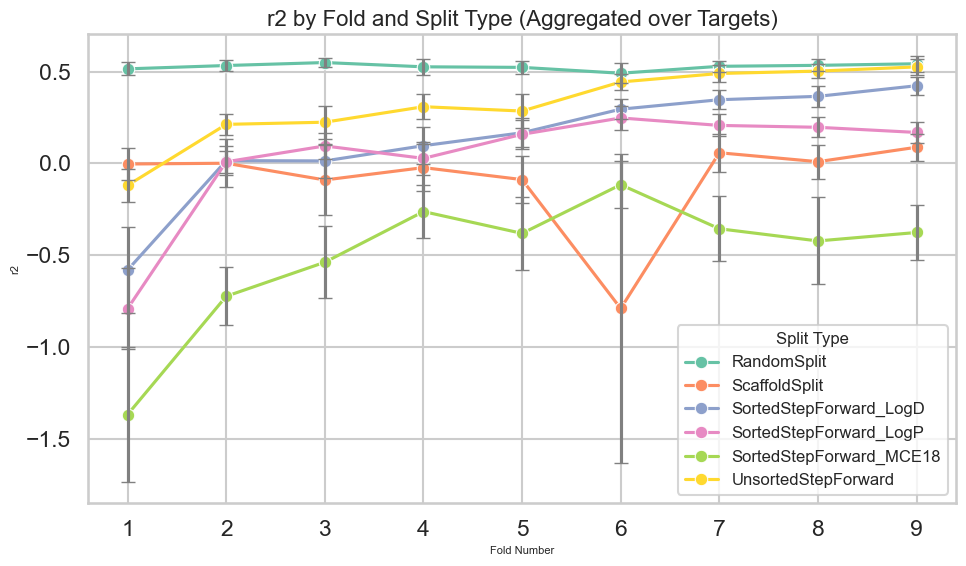

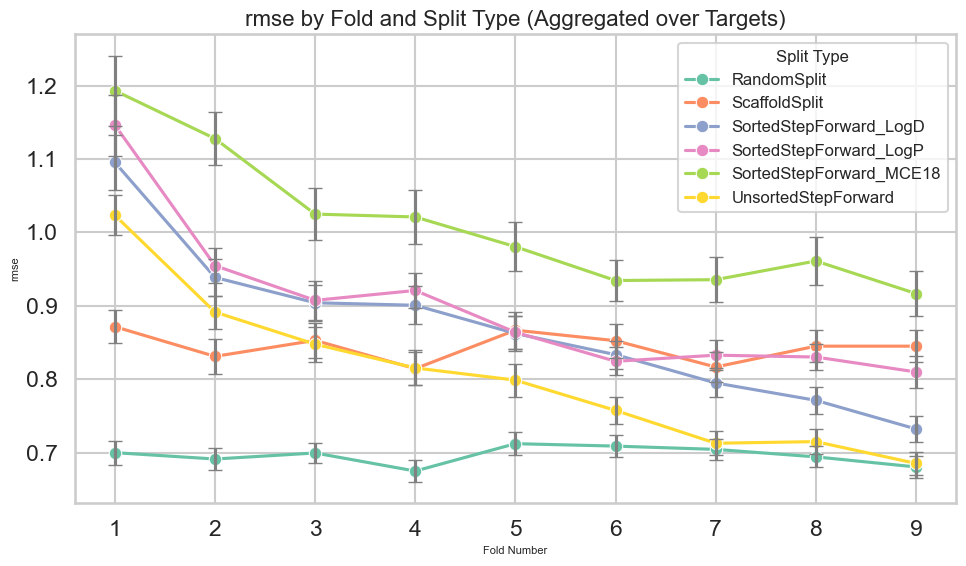

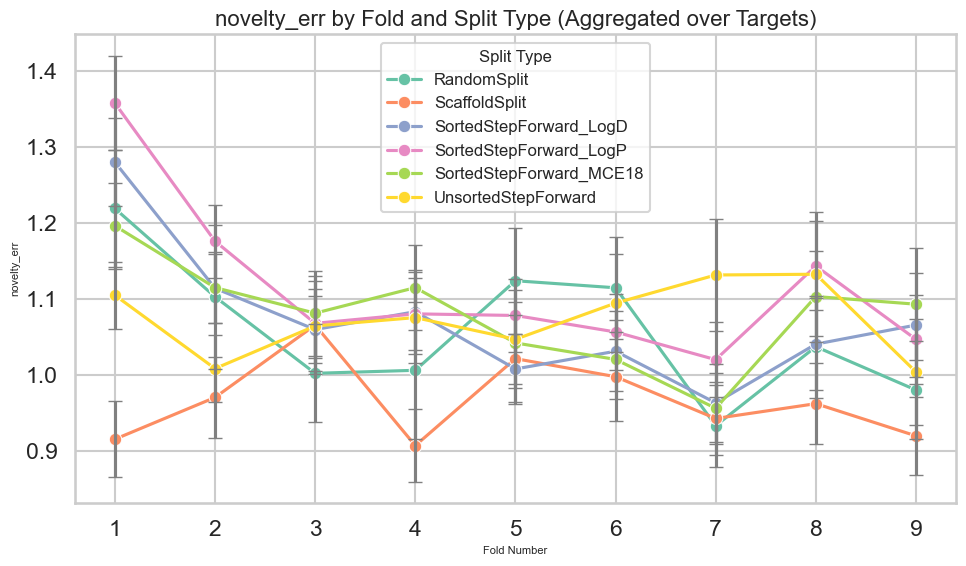

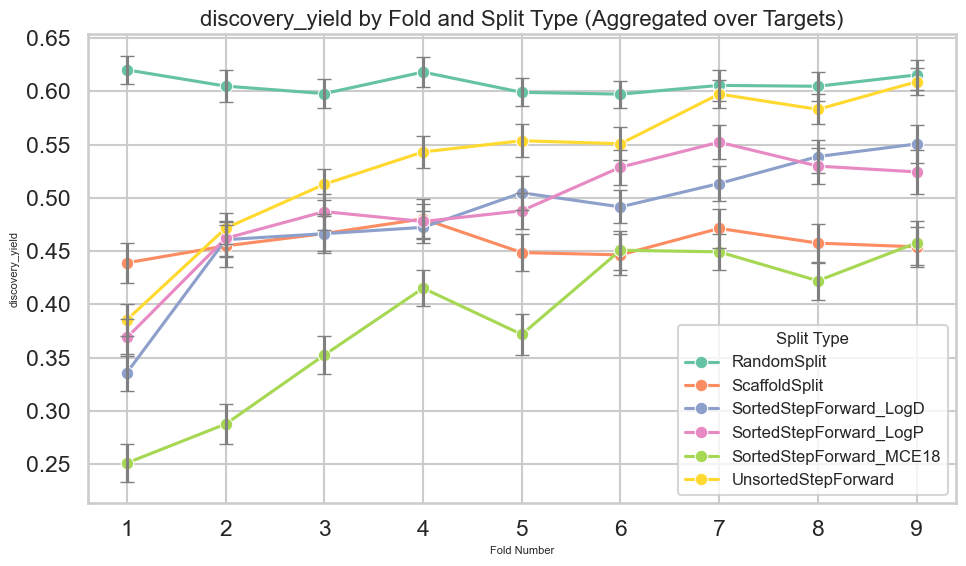

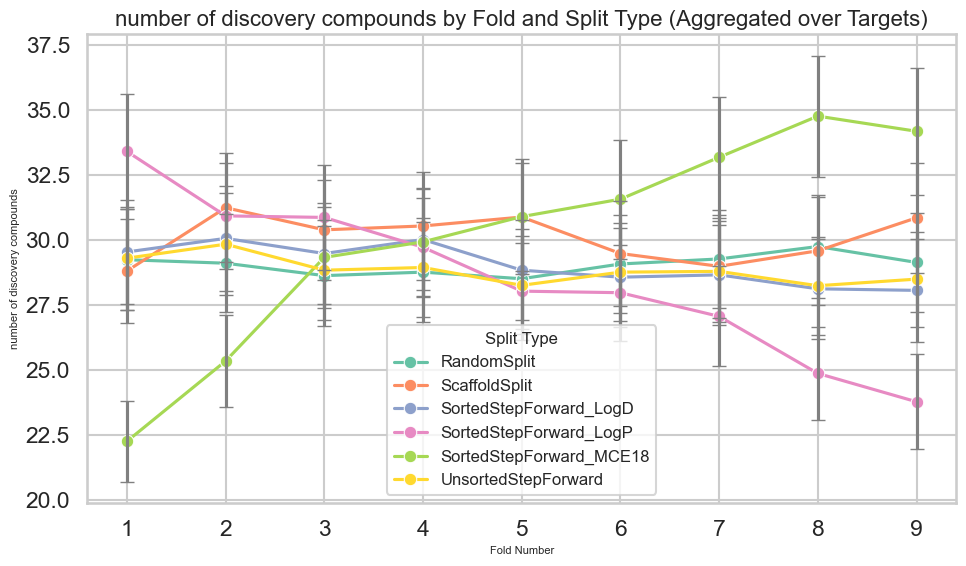

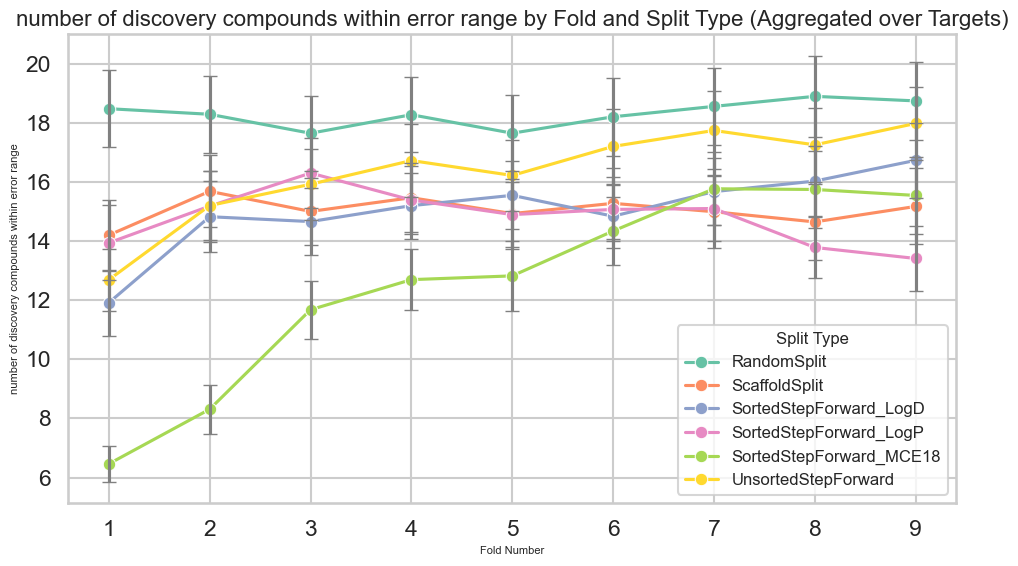

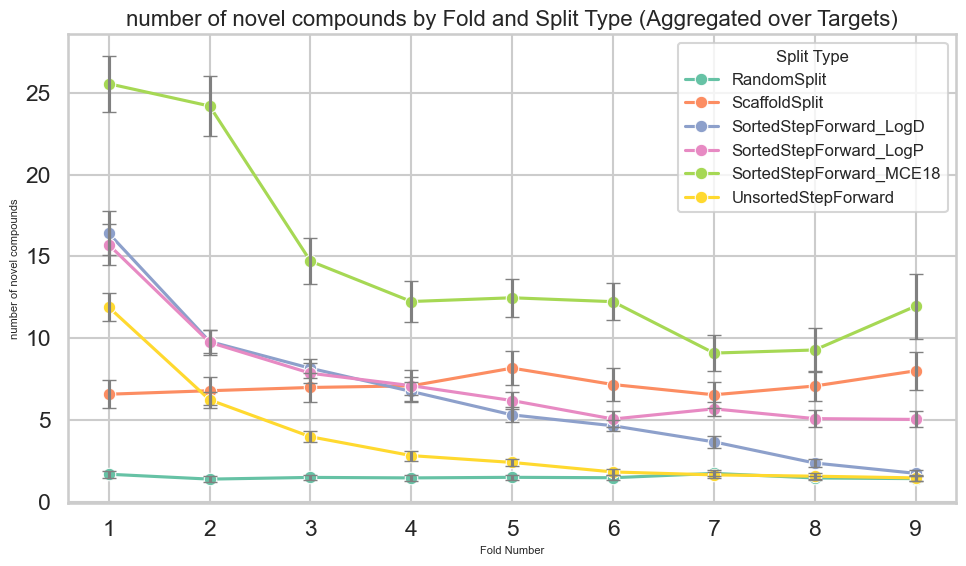

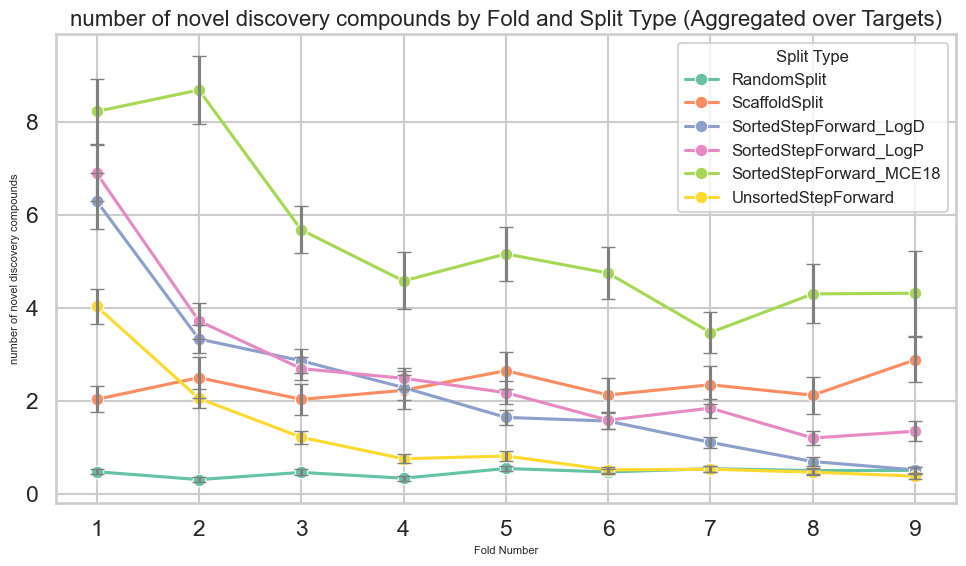

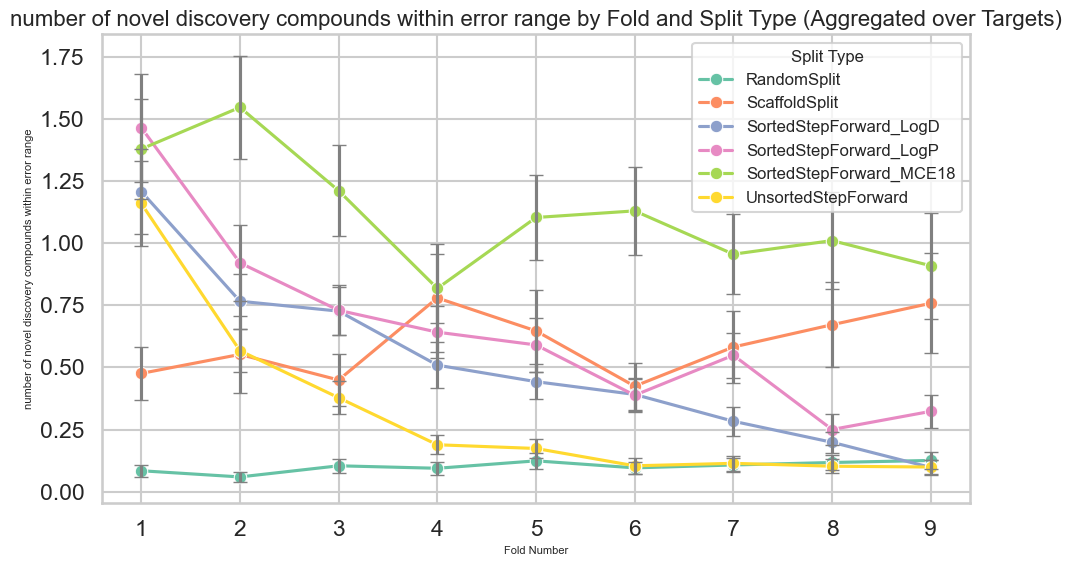

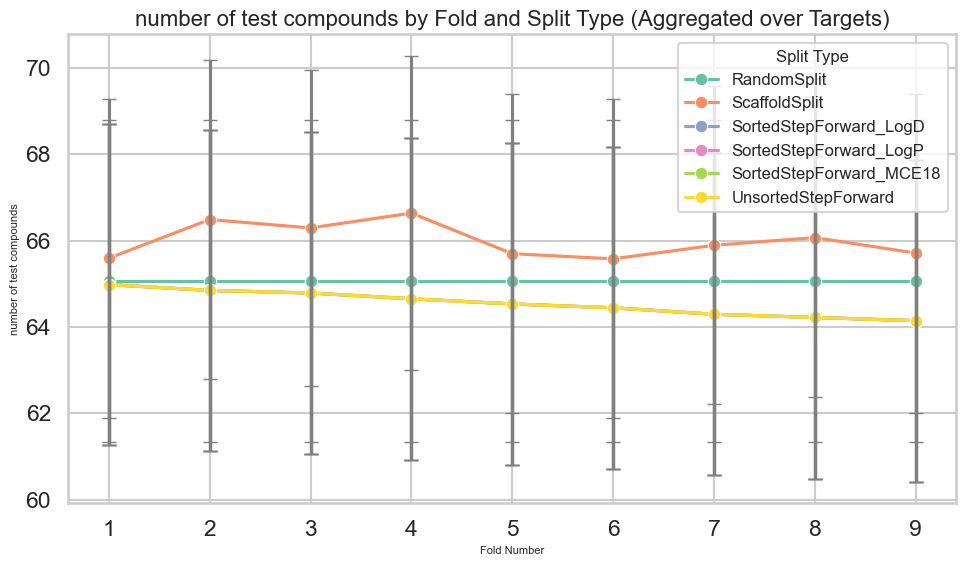

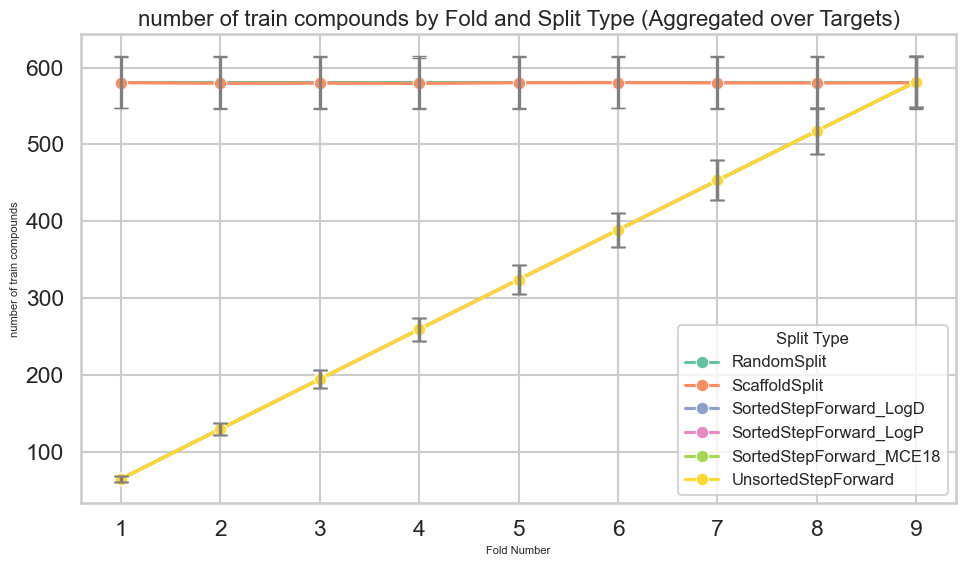

In [27]:
# metric = 'number of novel discovery compounds within error range'
for metric in metric_cols:
    agg_df = df.groupby(['fold_no', 'split_type'])[metric].agg(['mean', 'std', 'count']).reset_index()
    agg_df['se'] = agg_df['std'] / np.sqrt(agg_df['count'])
    agg_df['ci'] = 1.96 * agg_df['se']  # 95% confidence interval

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=agg_df, x='fold_no', y='mean', hue='split_type', marker='o', palette='Set2')
    # Manually add error bars
    for split in agg_df['split_type'].unique():
        sub = agg_df[agg_df['split_type'] == split]
        plt.errorbar(sub['fold_no'], sub['mean'], yerr=sub['ci'], fmt='none', capsize=5, color='gray')
    plt.title(f'{metric} by Fold and Split Type (Aggregated over Targets)', fontsize=16)
    plt.xlabel('Fold Number', fontsize=8)
    plt.ylabel(metric, fontsize=8)
    plt.legend(title='Split Type', fontsize=12, title_fontsize=12)
    plt.tight_layout()
    plt.show()

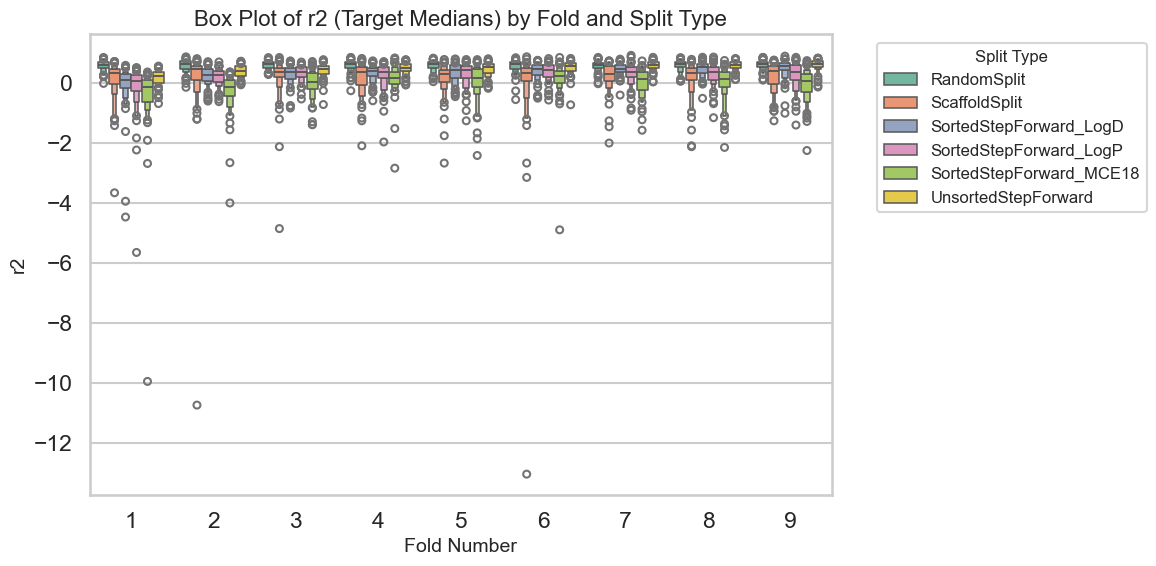

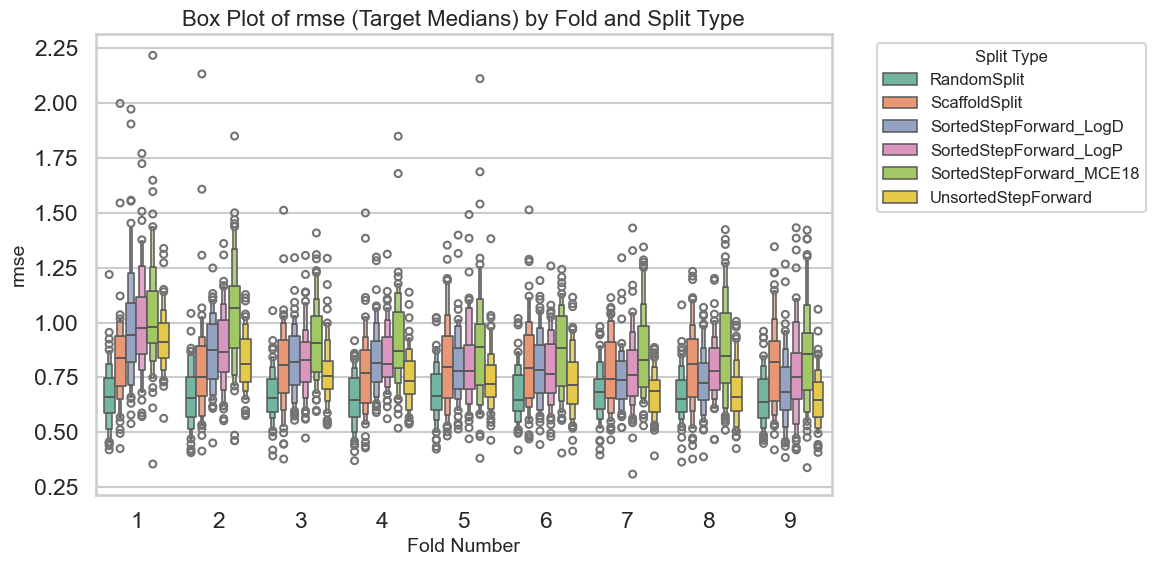

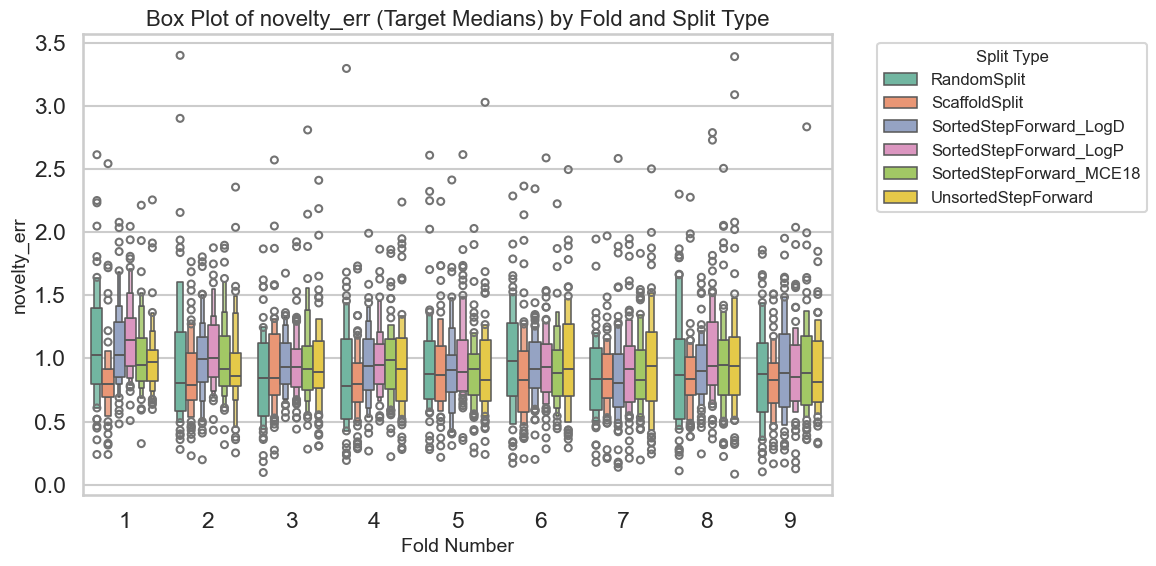

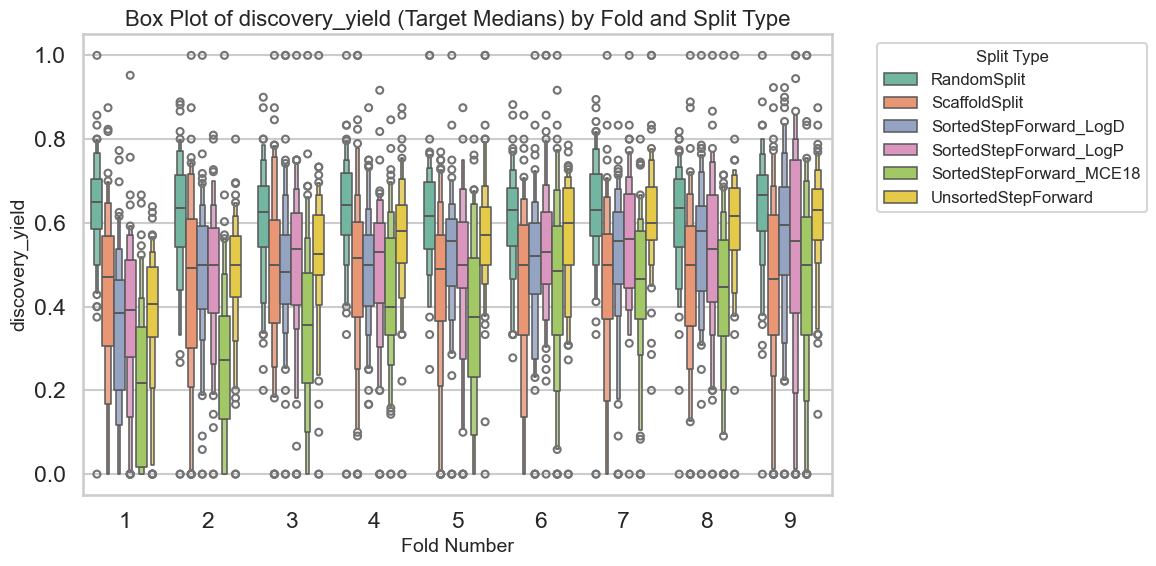

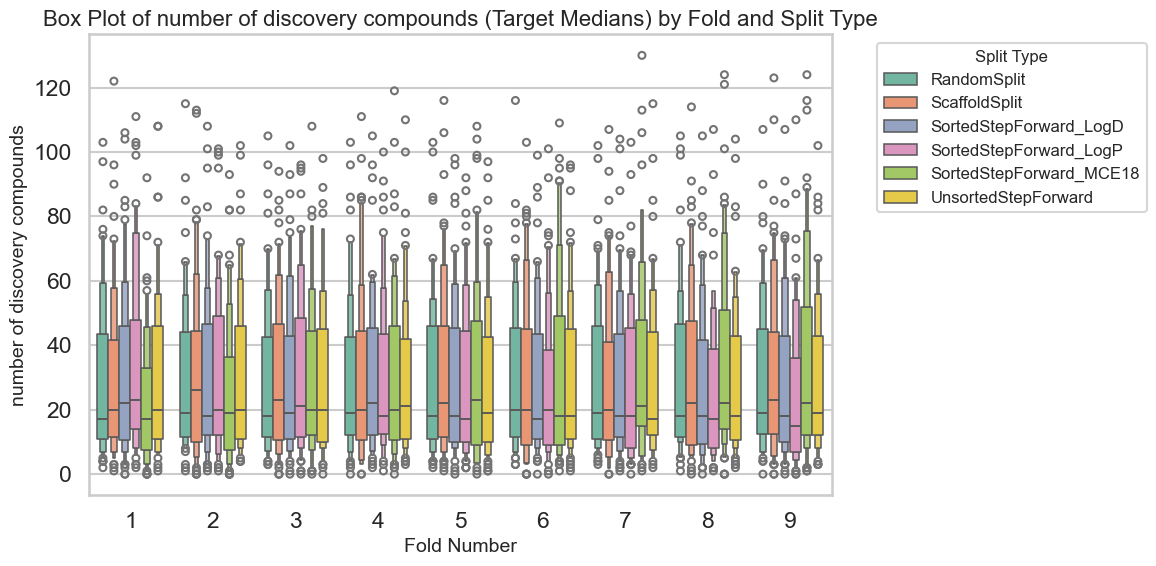

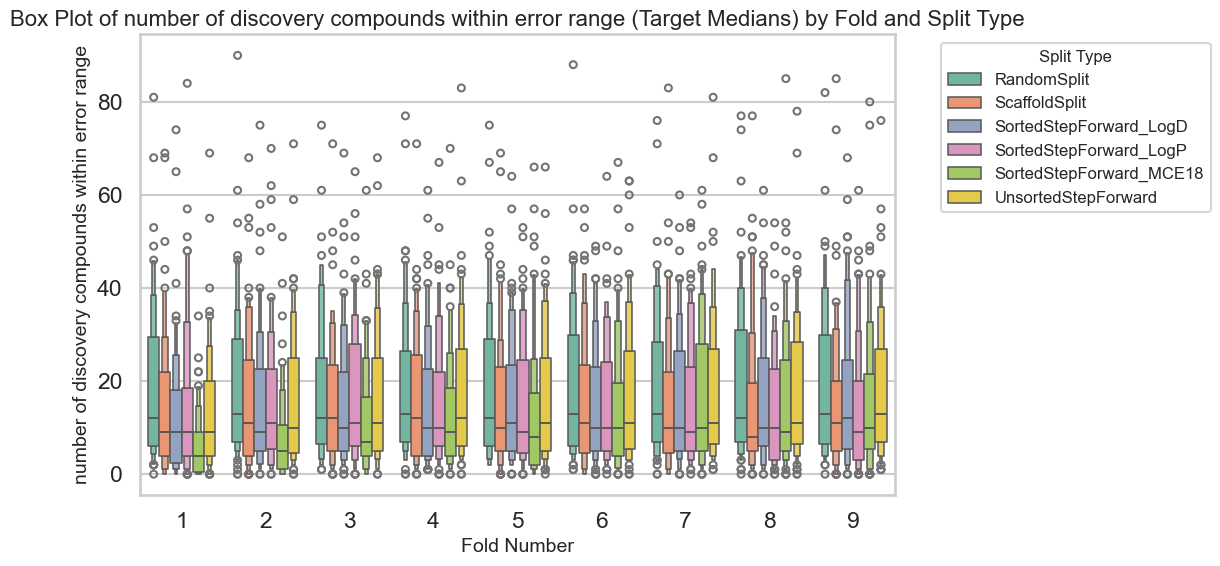

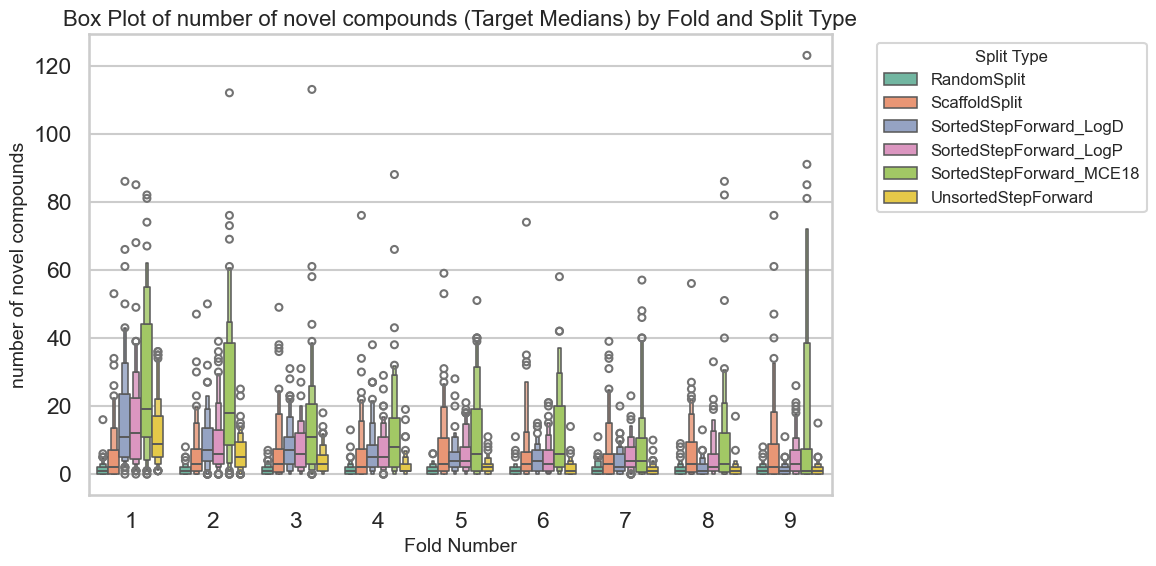

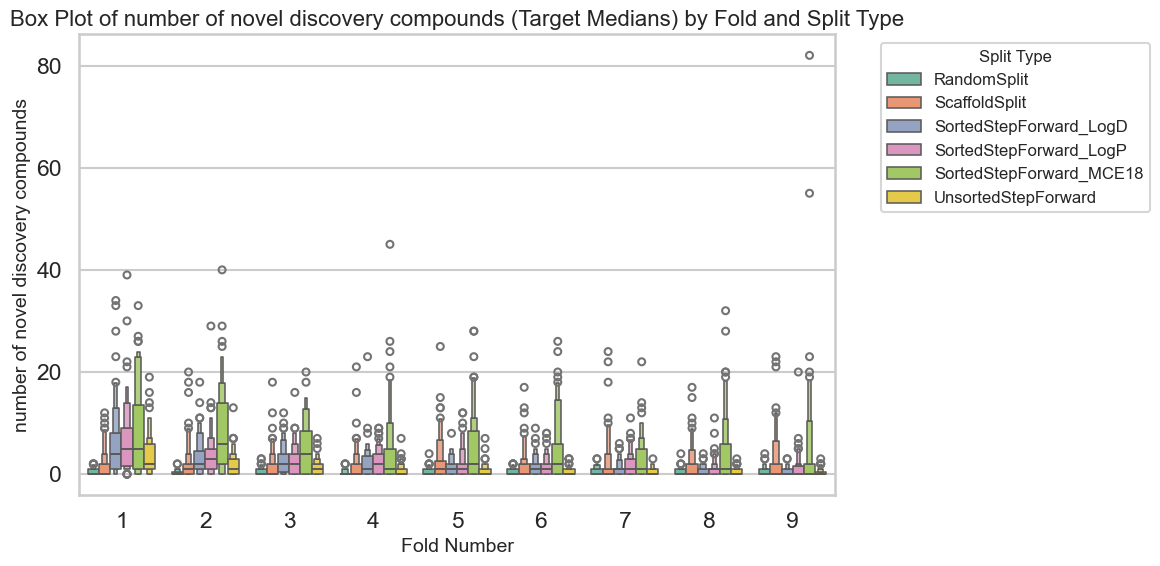

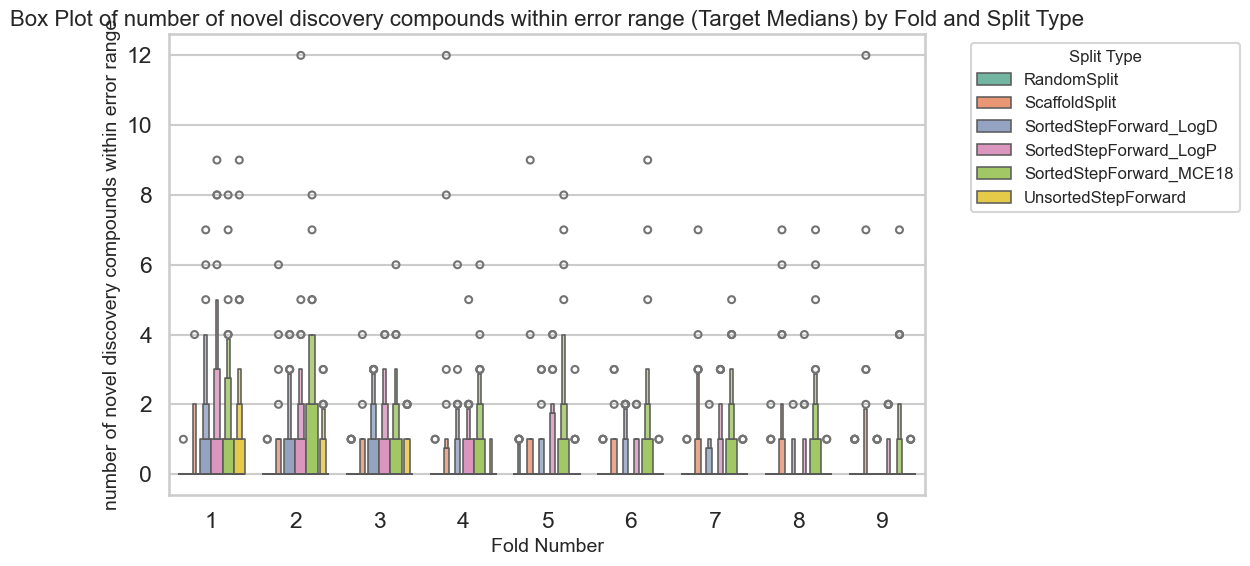

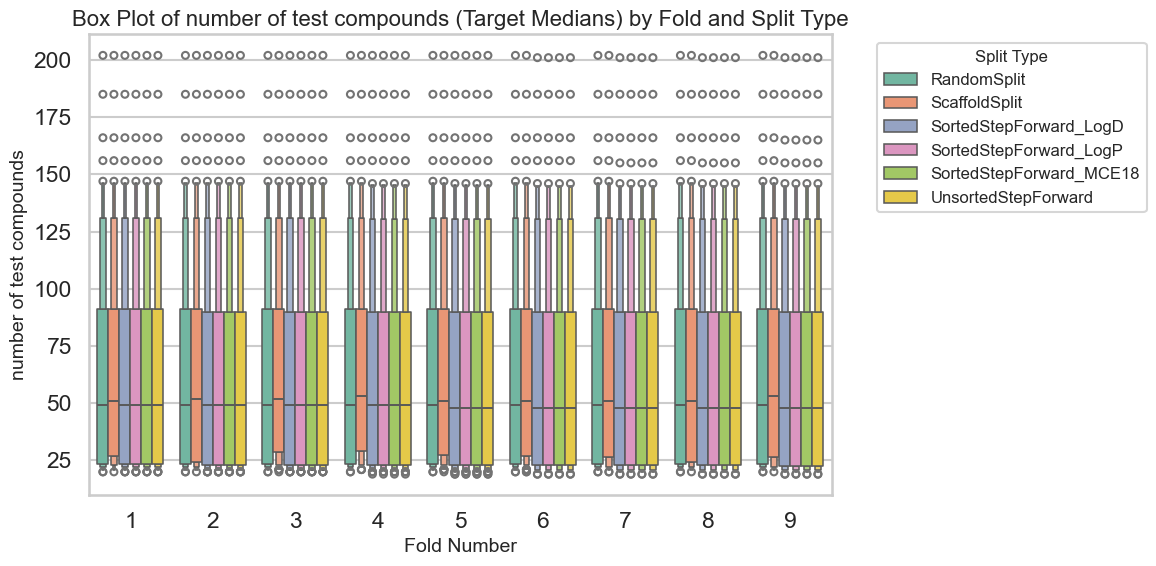

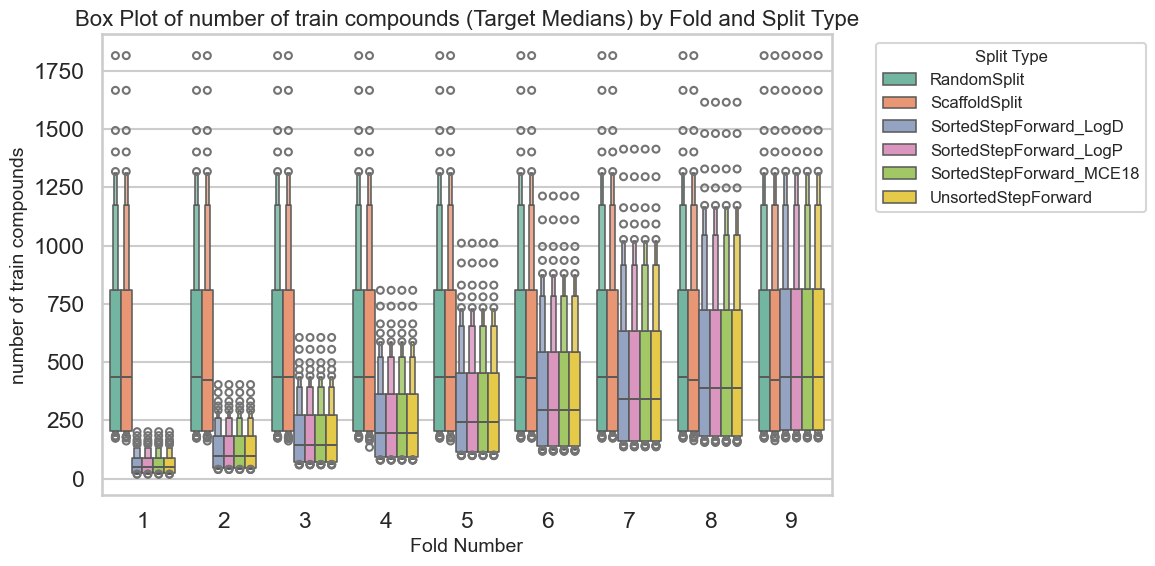

In [36]:
for metric in metric_cols:
    agg_targets = df.groupby(['target', 'fold_no', 'split_type'])[metric].median().reset_index()

    plt.figure(figsize=(12, 6))
    sns.boxenplot(data=agg_targets, x='fold_no', y=metric, hue='split_type', palette='Set2')
    plt.title(f'Box Plot of {metric} (Target Medians) by Fold and Split Type', fontsize=16)
    plt.xlabel('Fold Number', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.legend(title='Split Type', fontsize=12, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

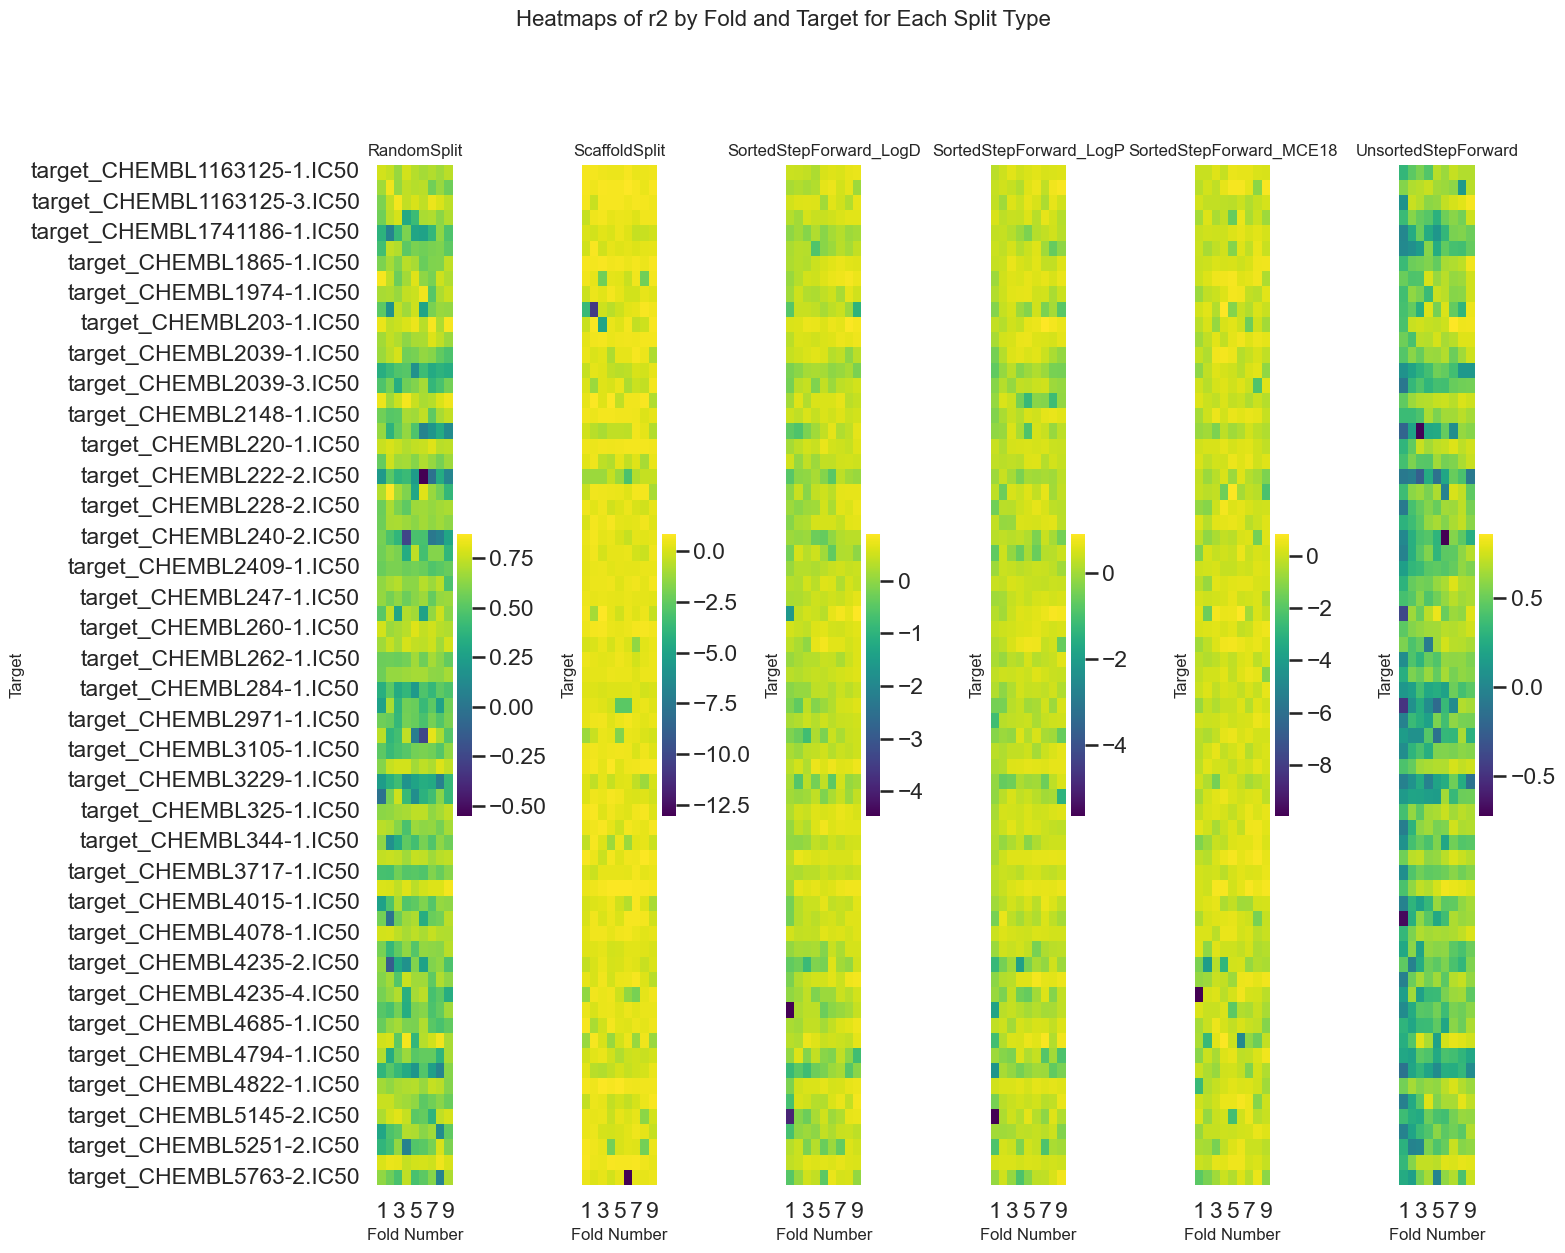

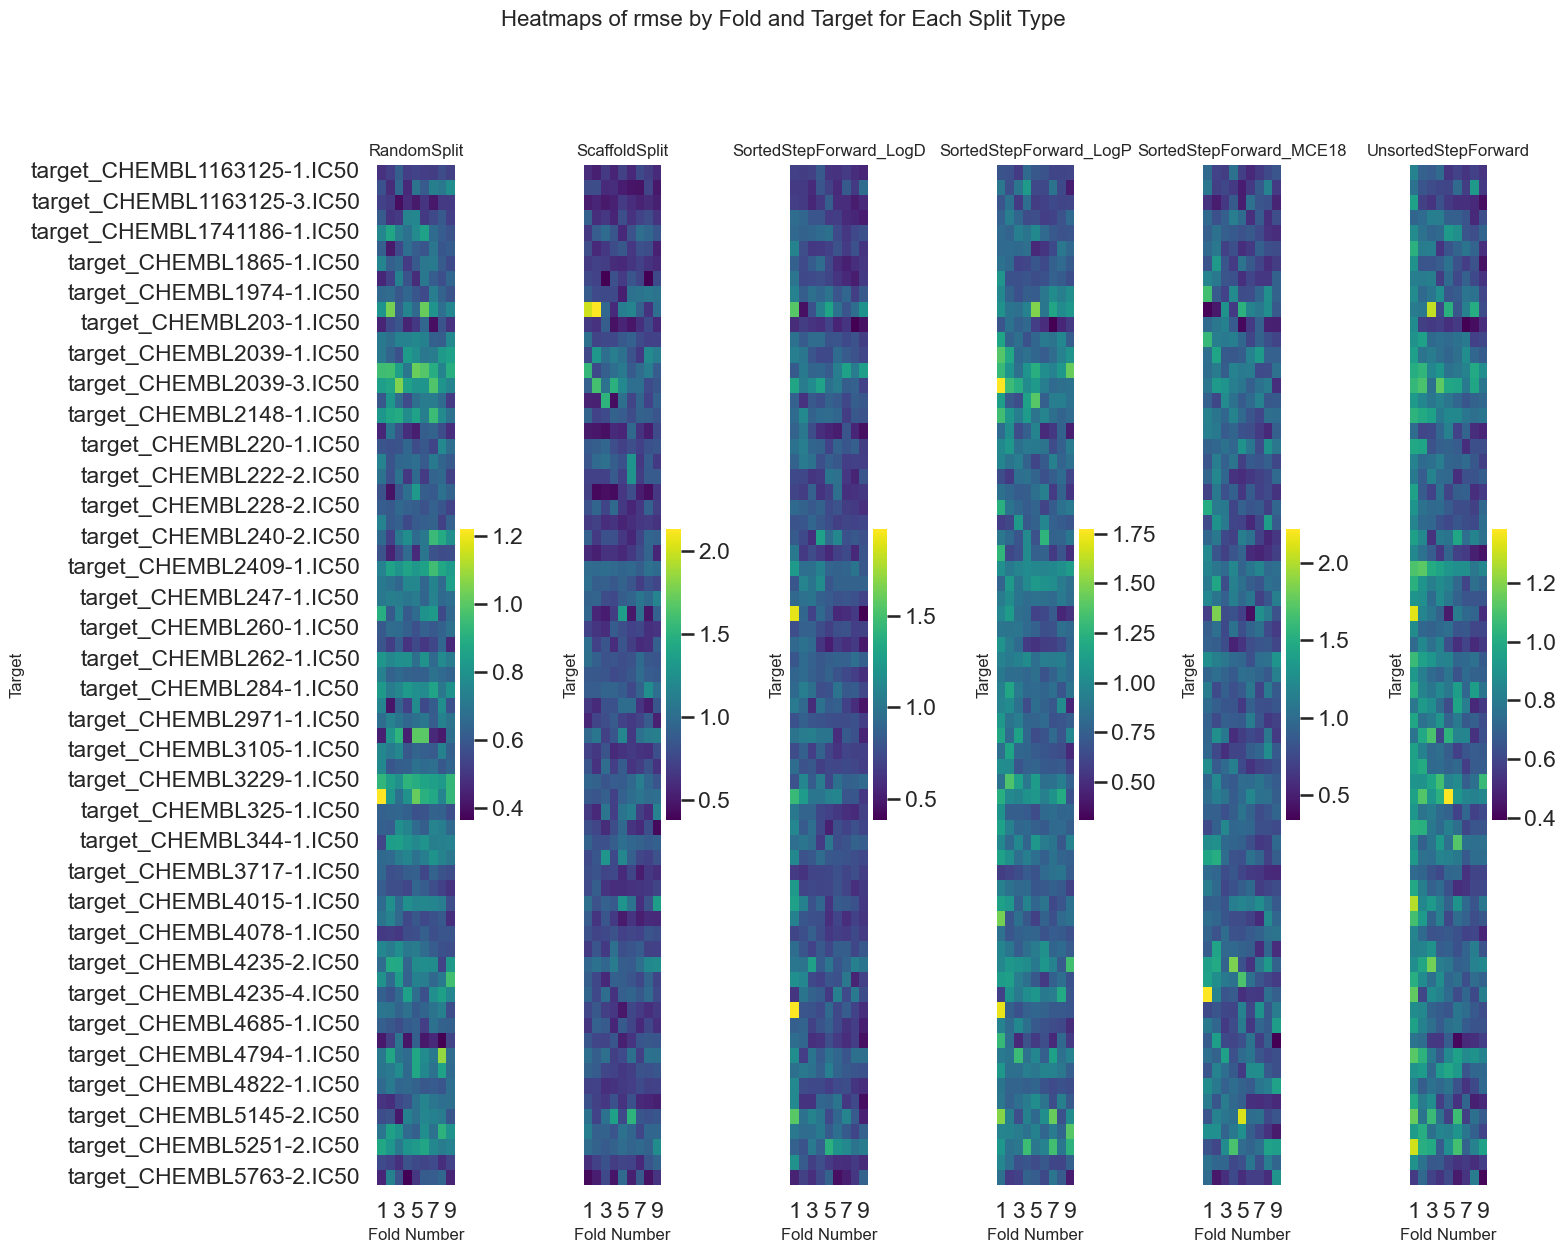

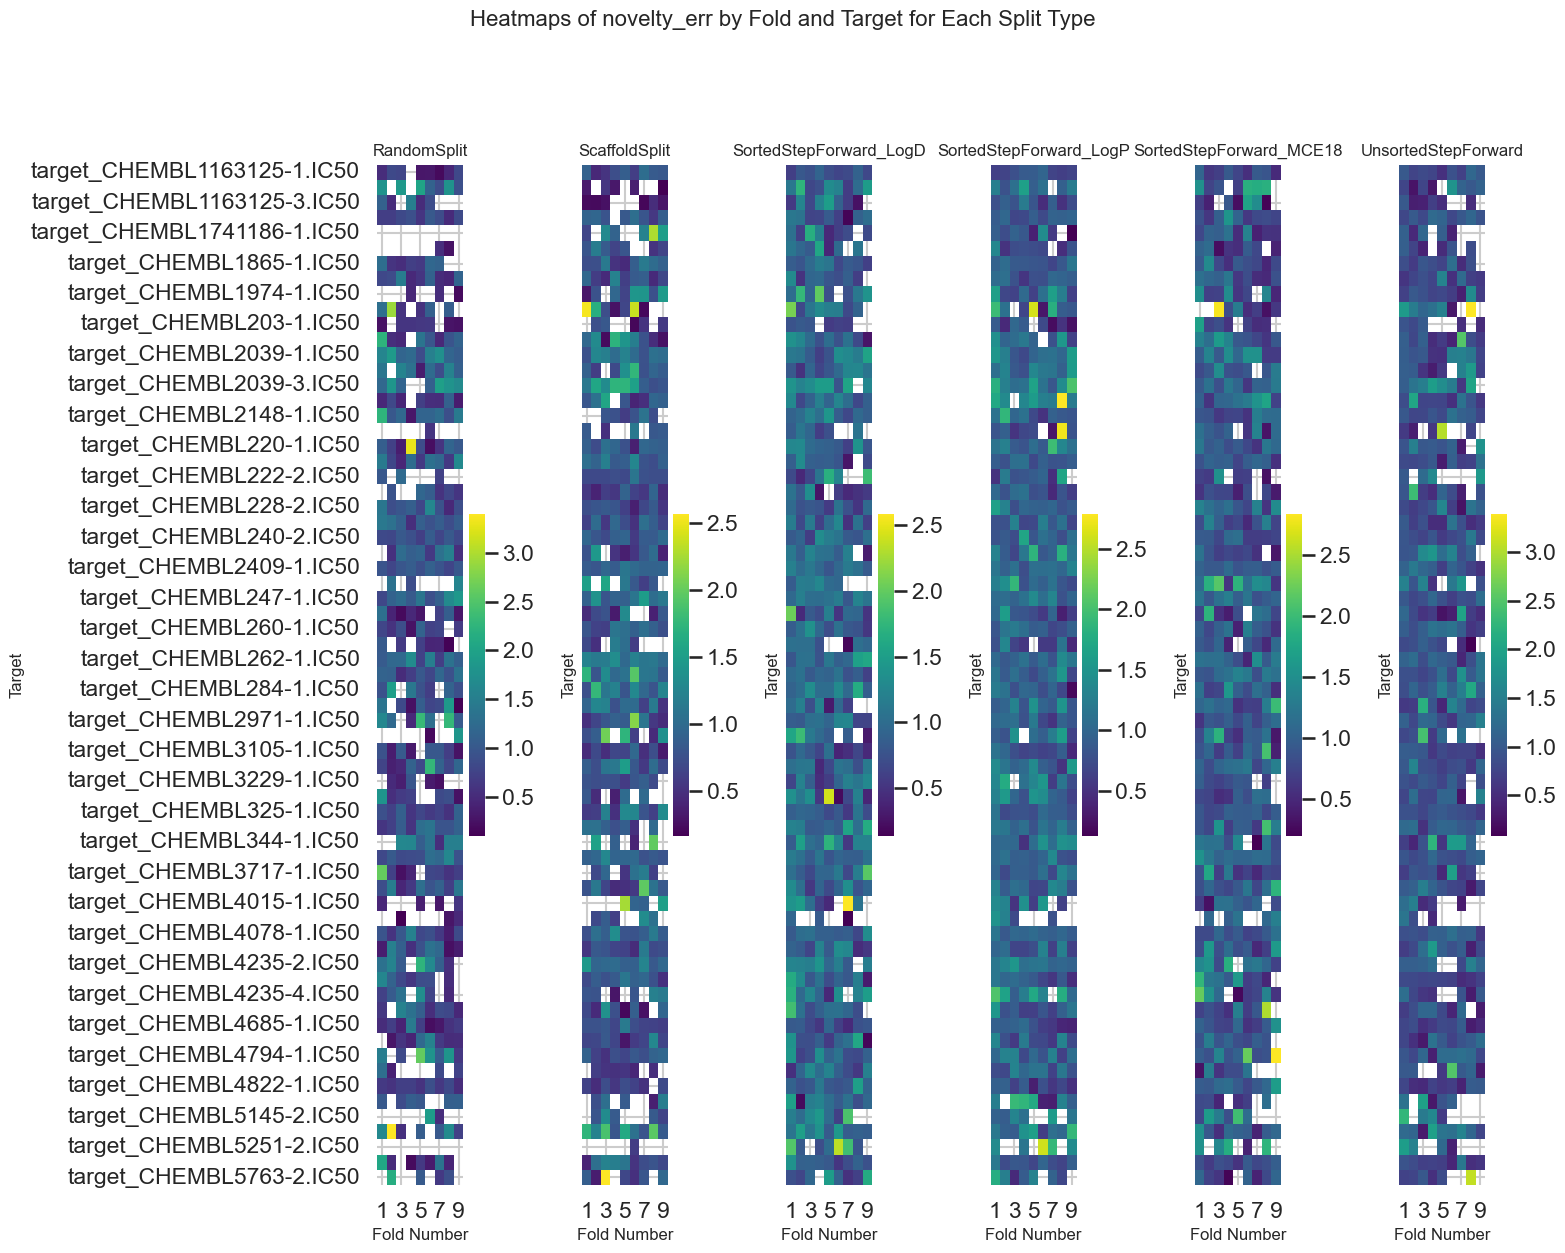

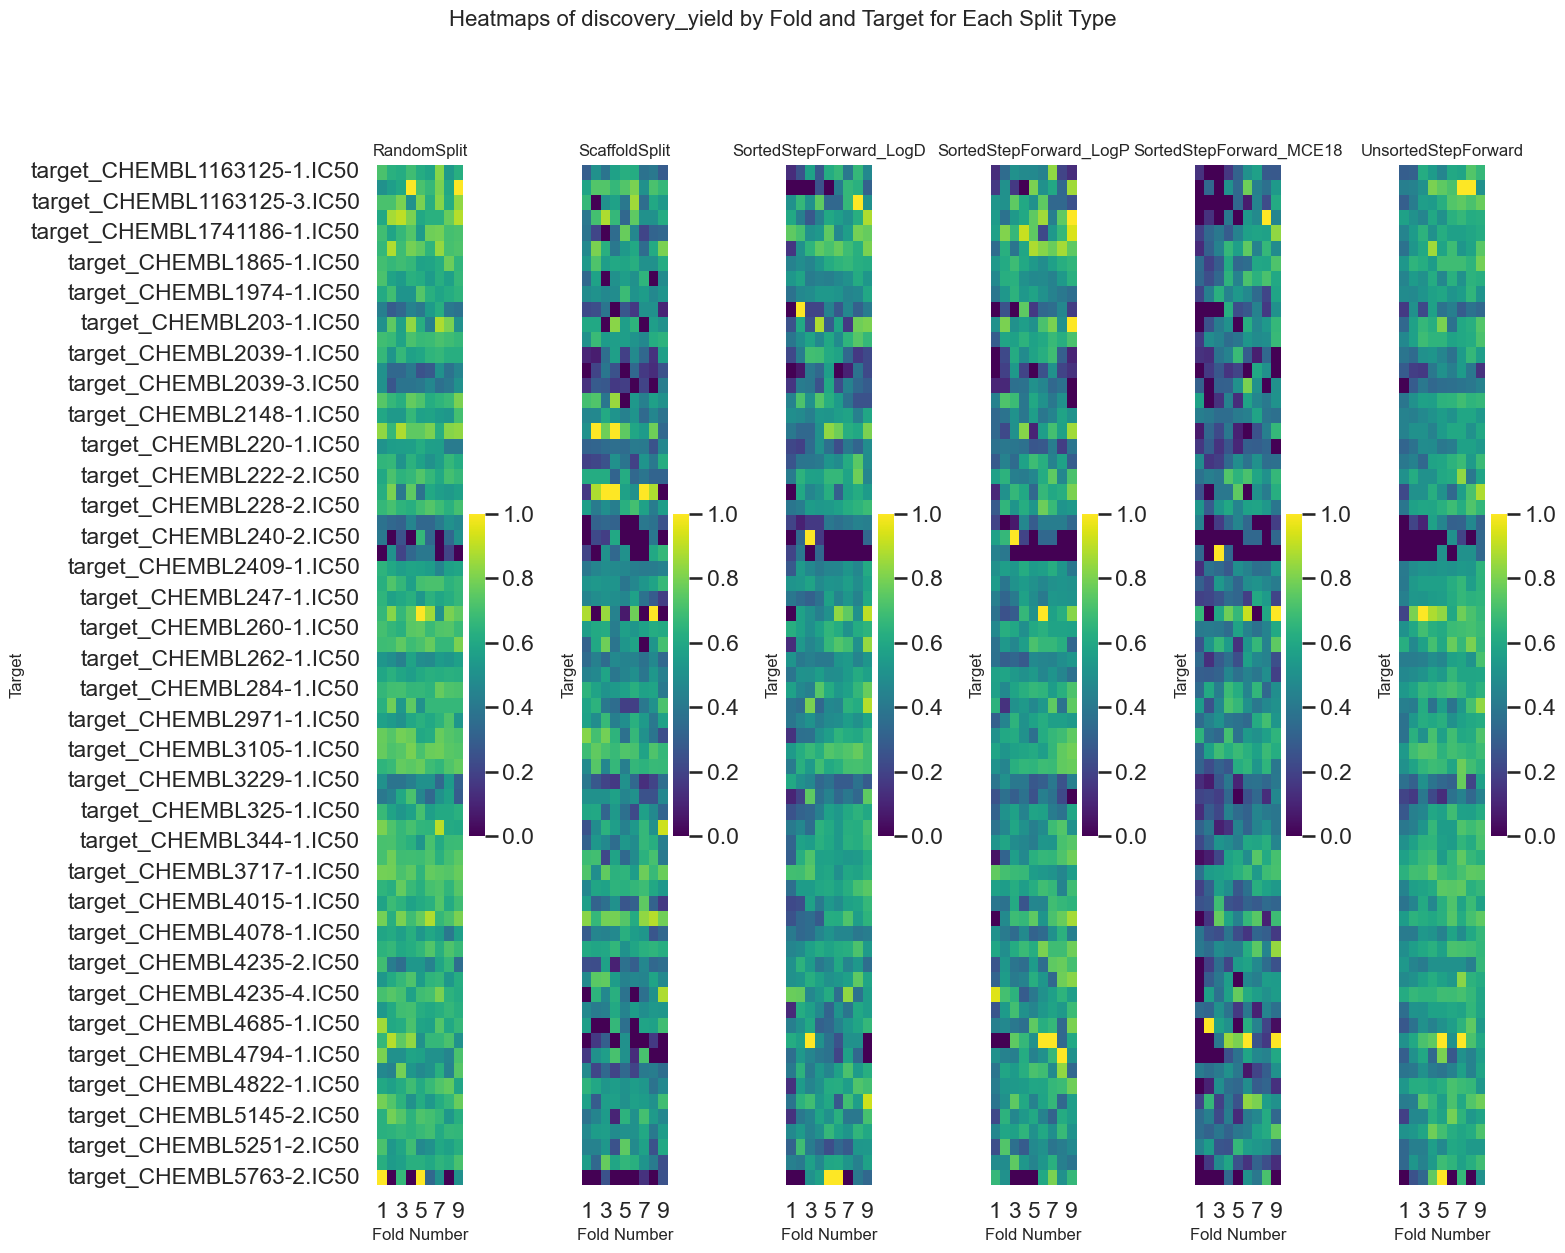

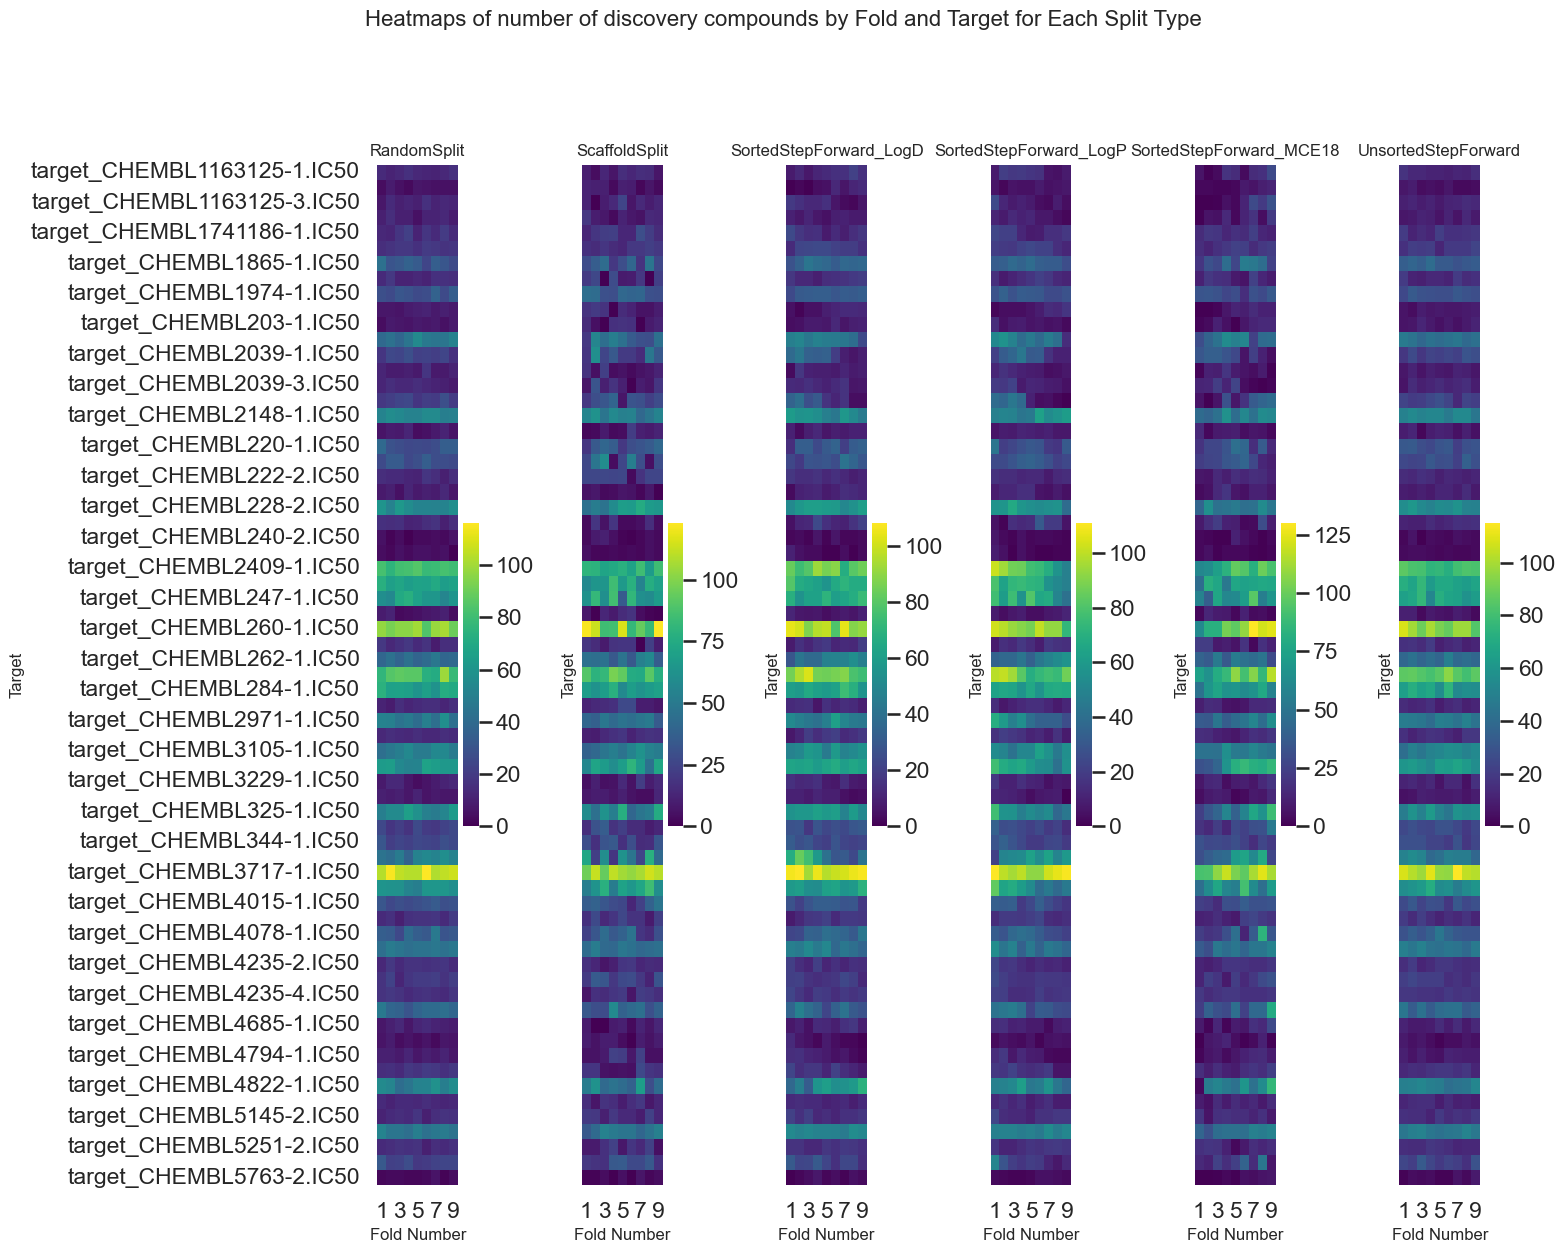

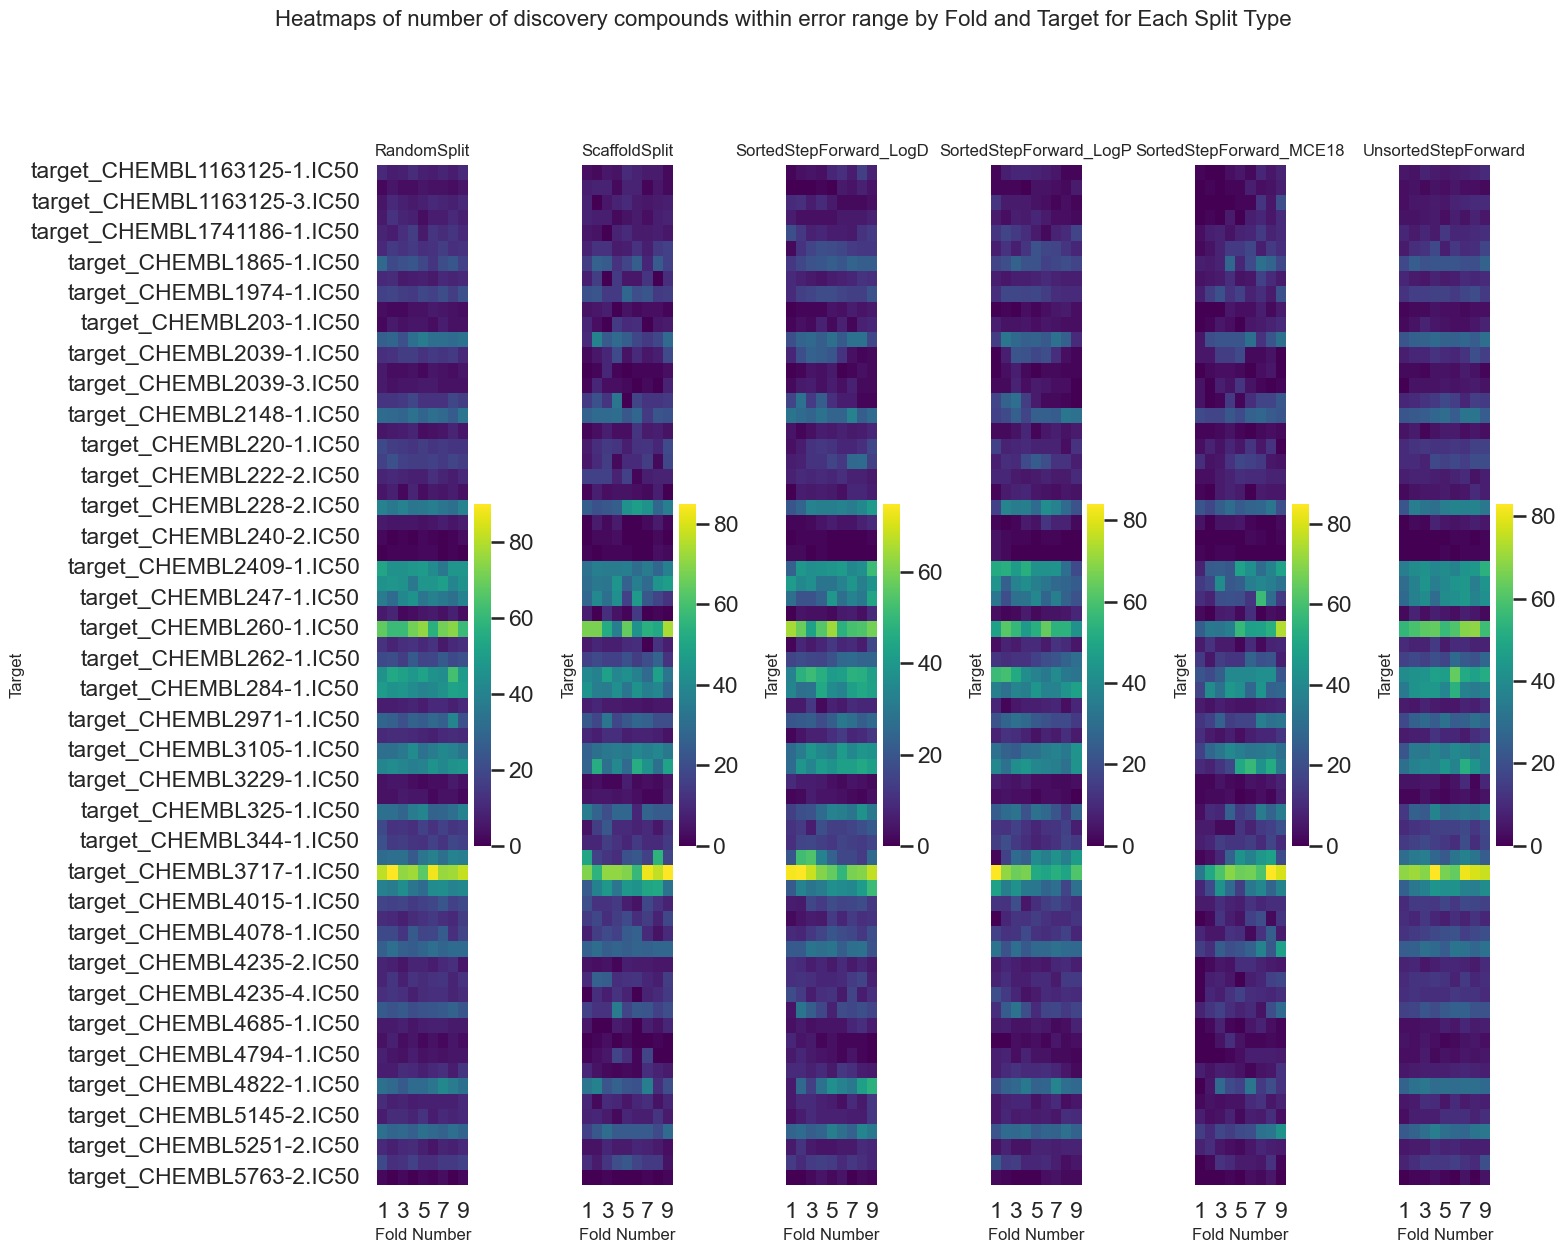

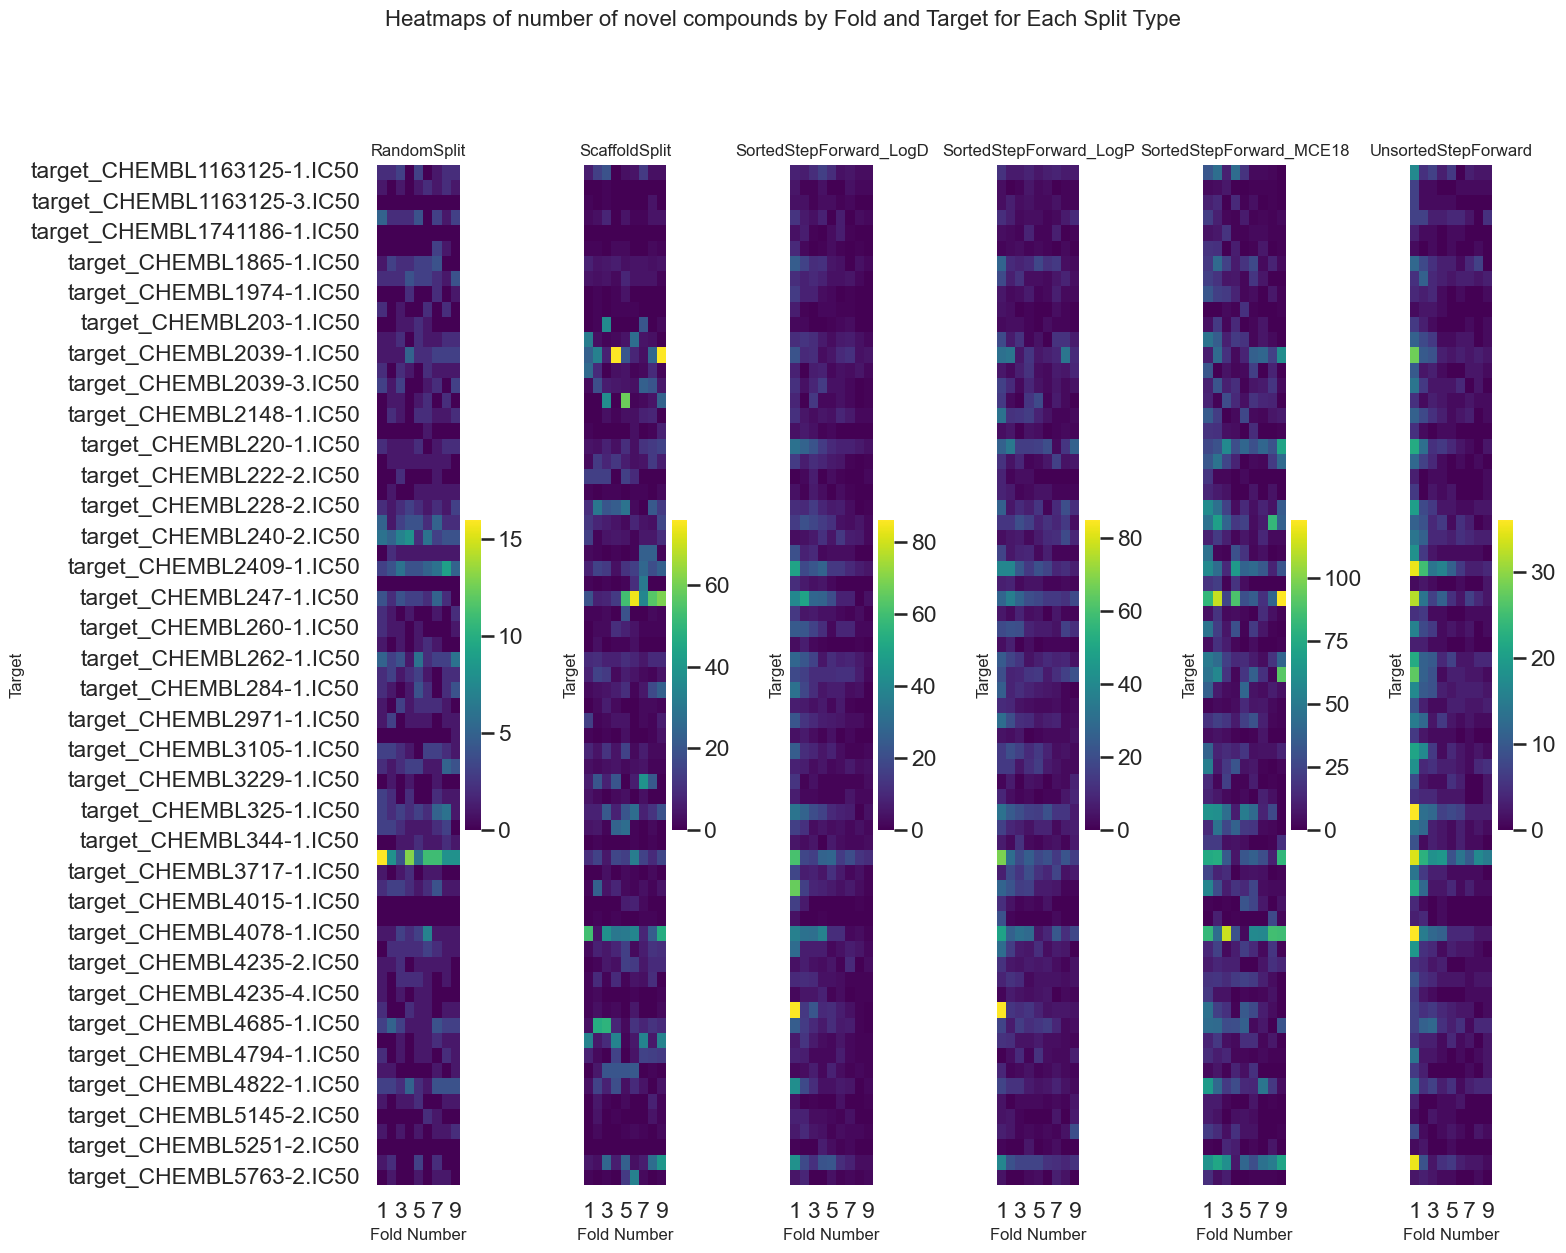

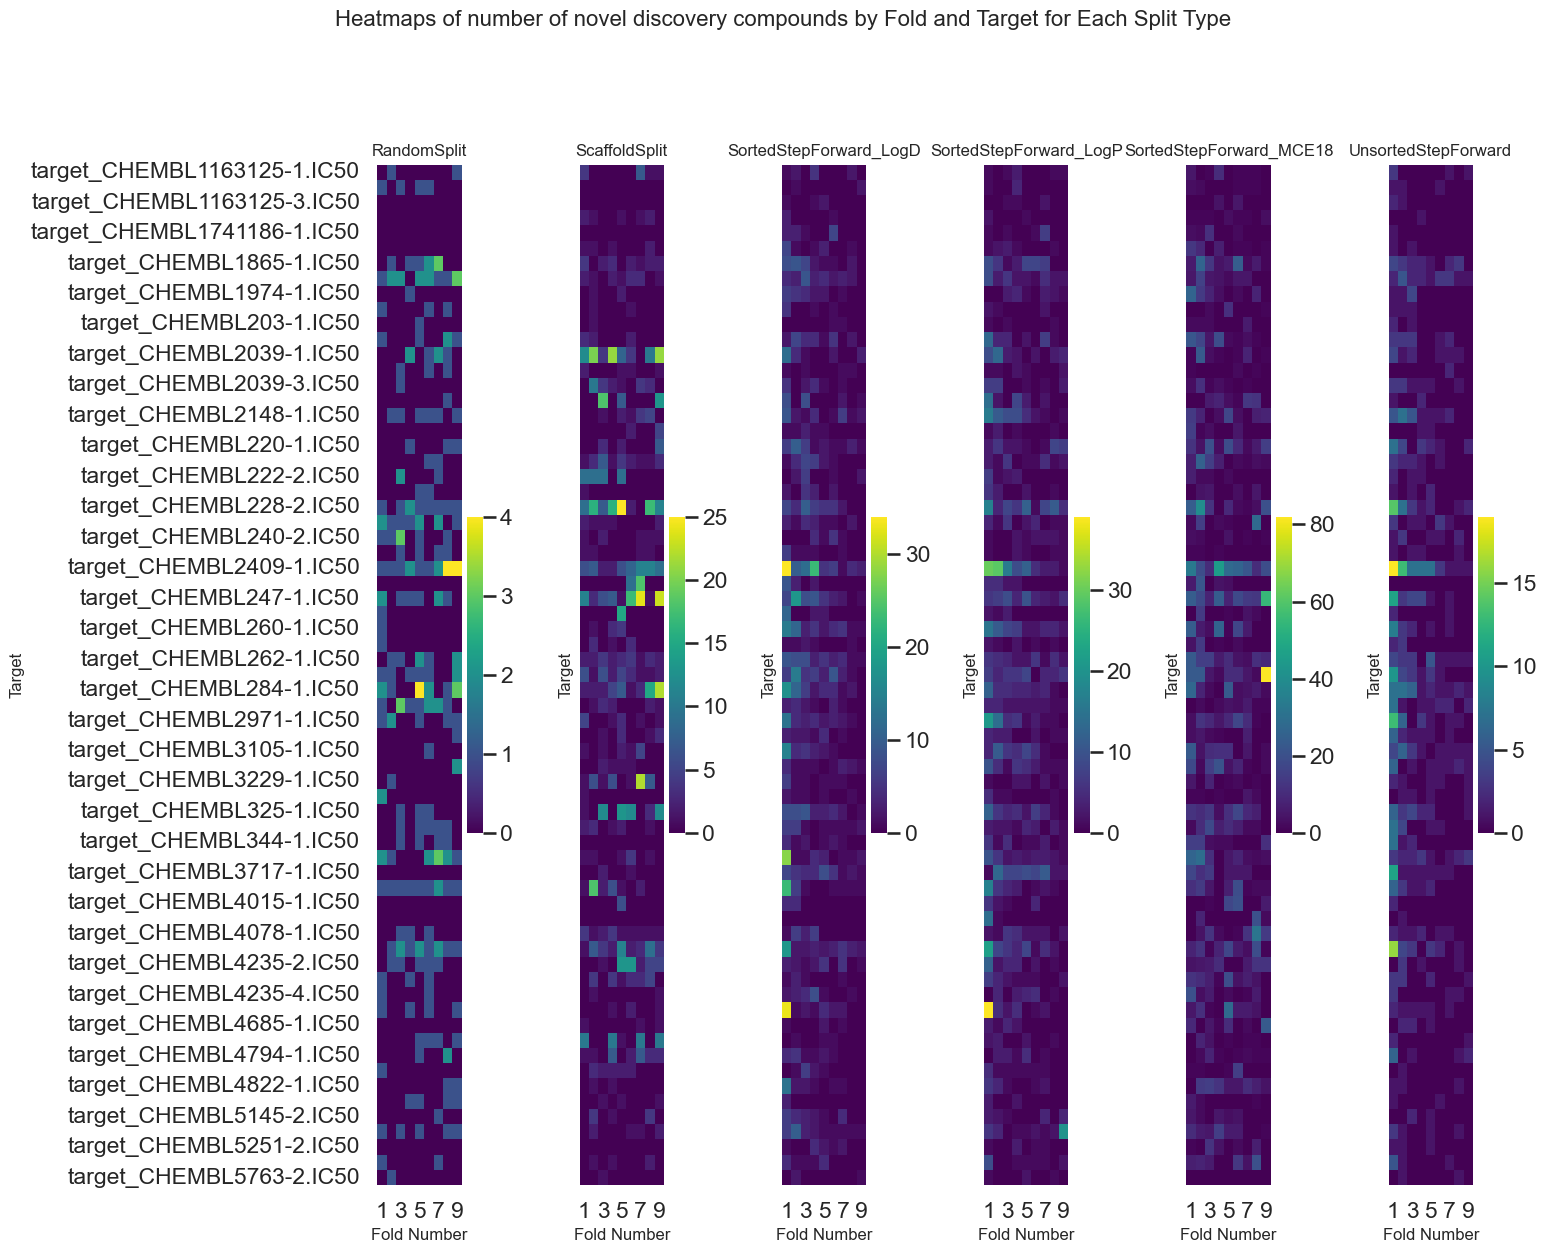

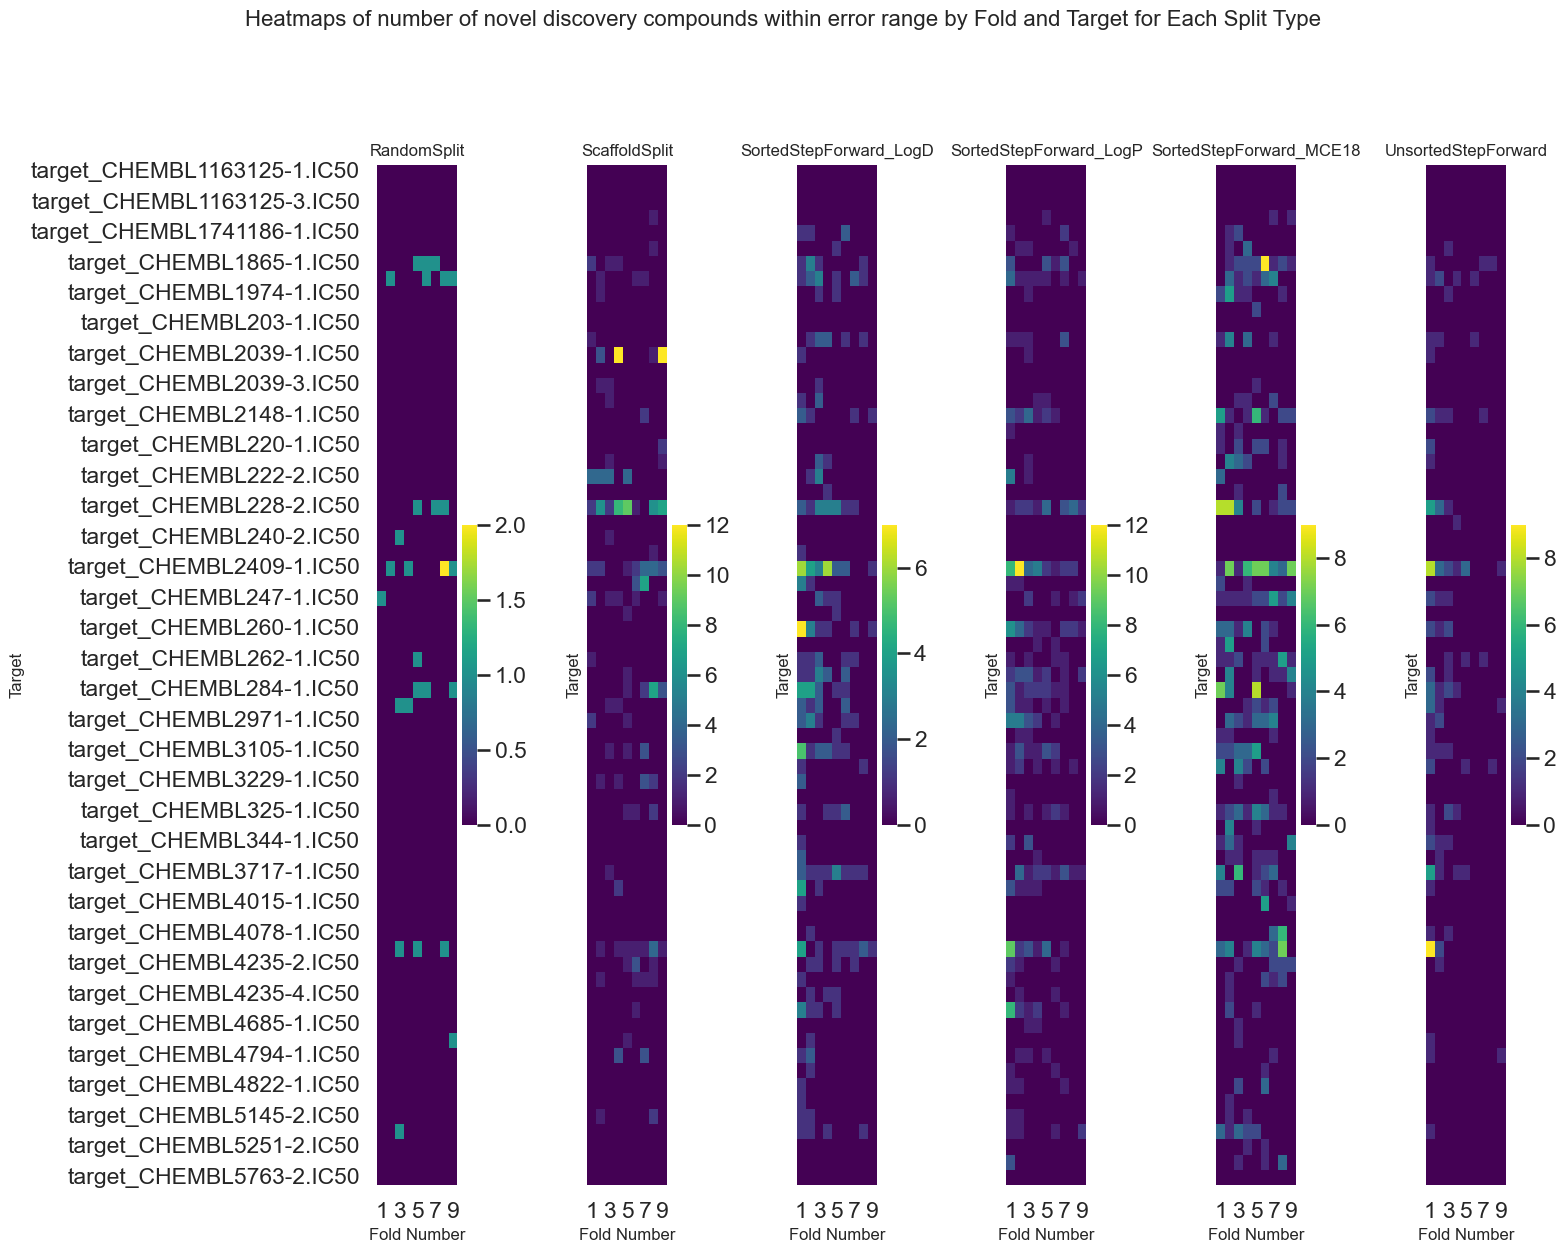

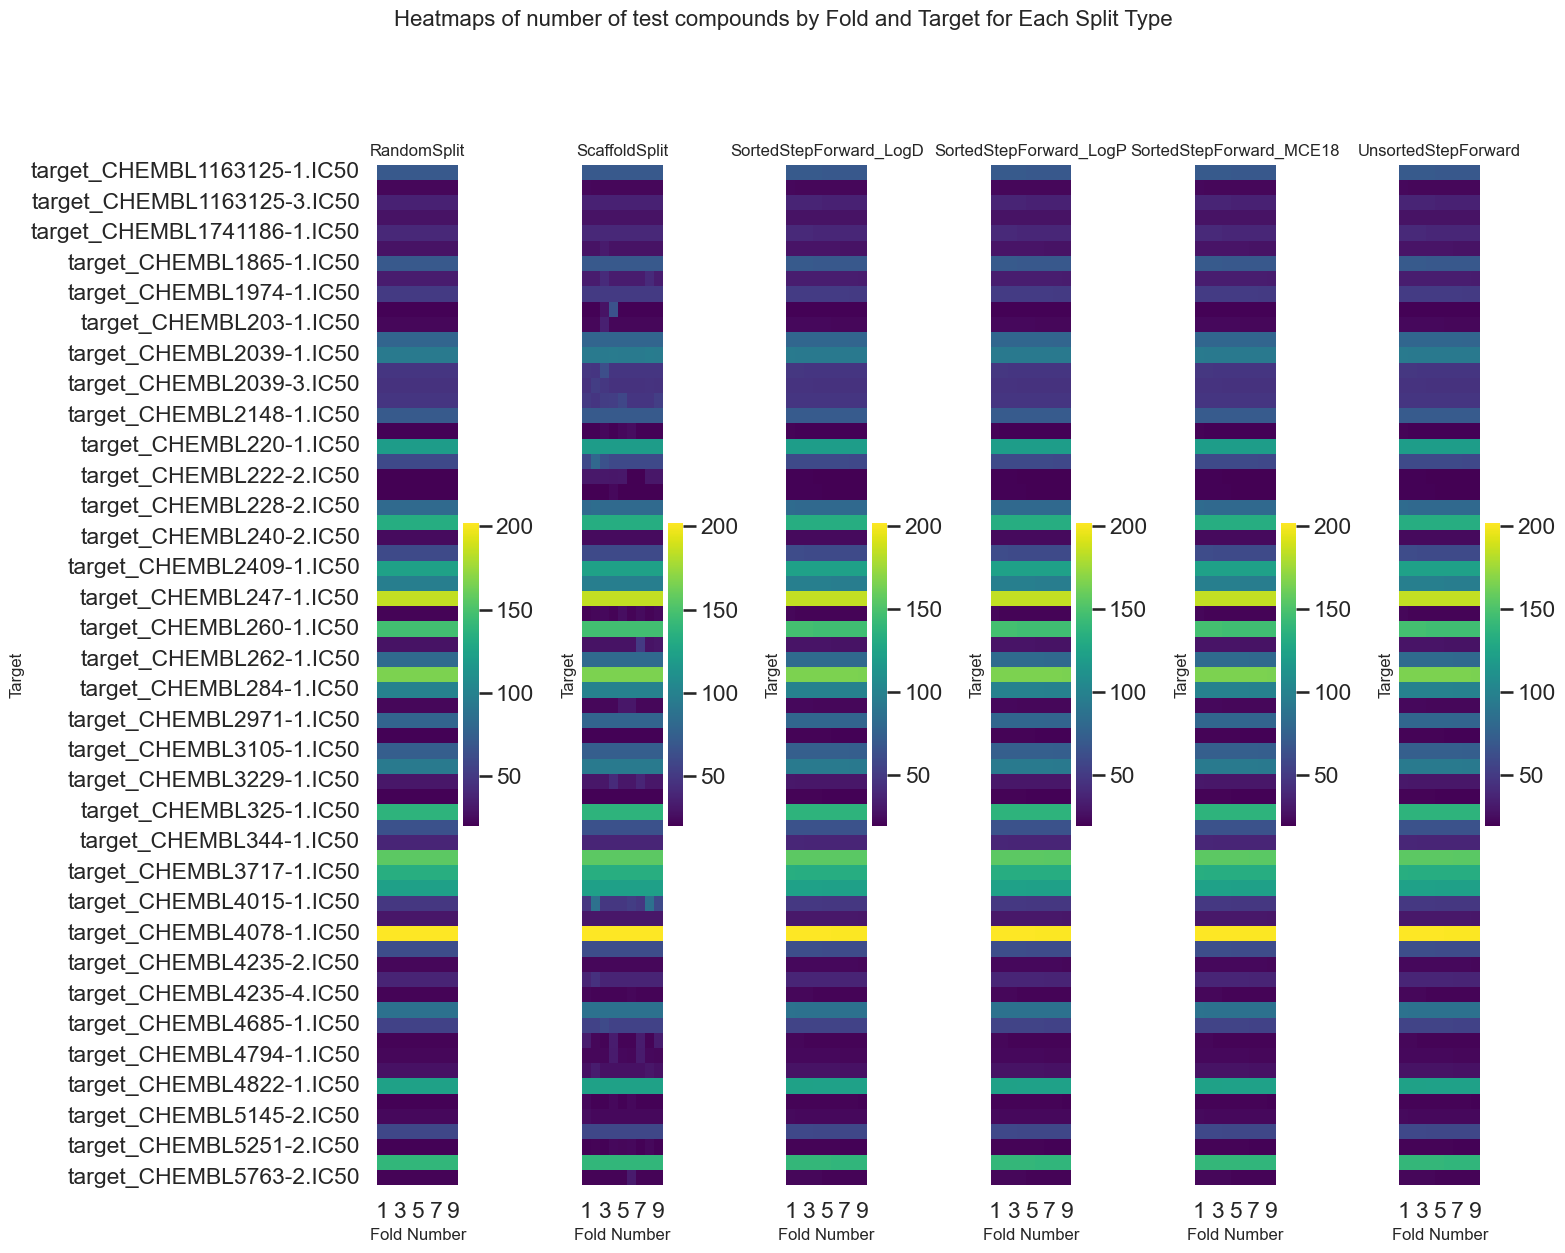

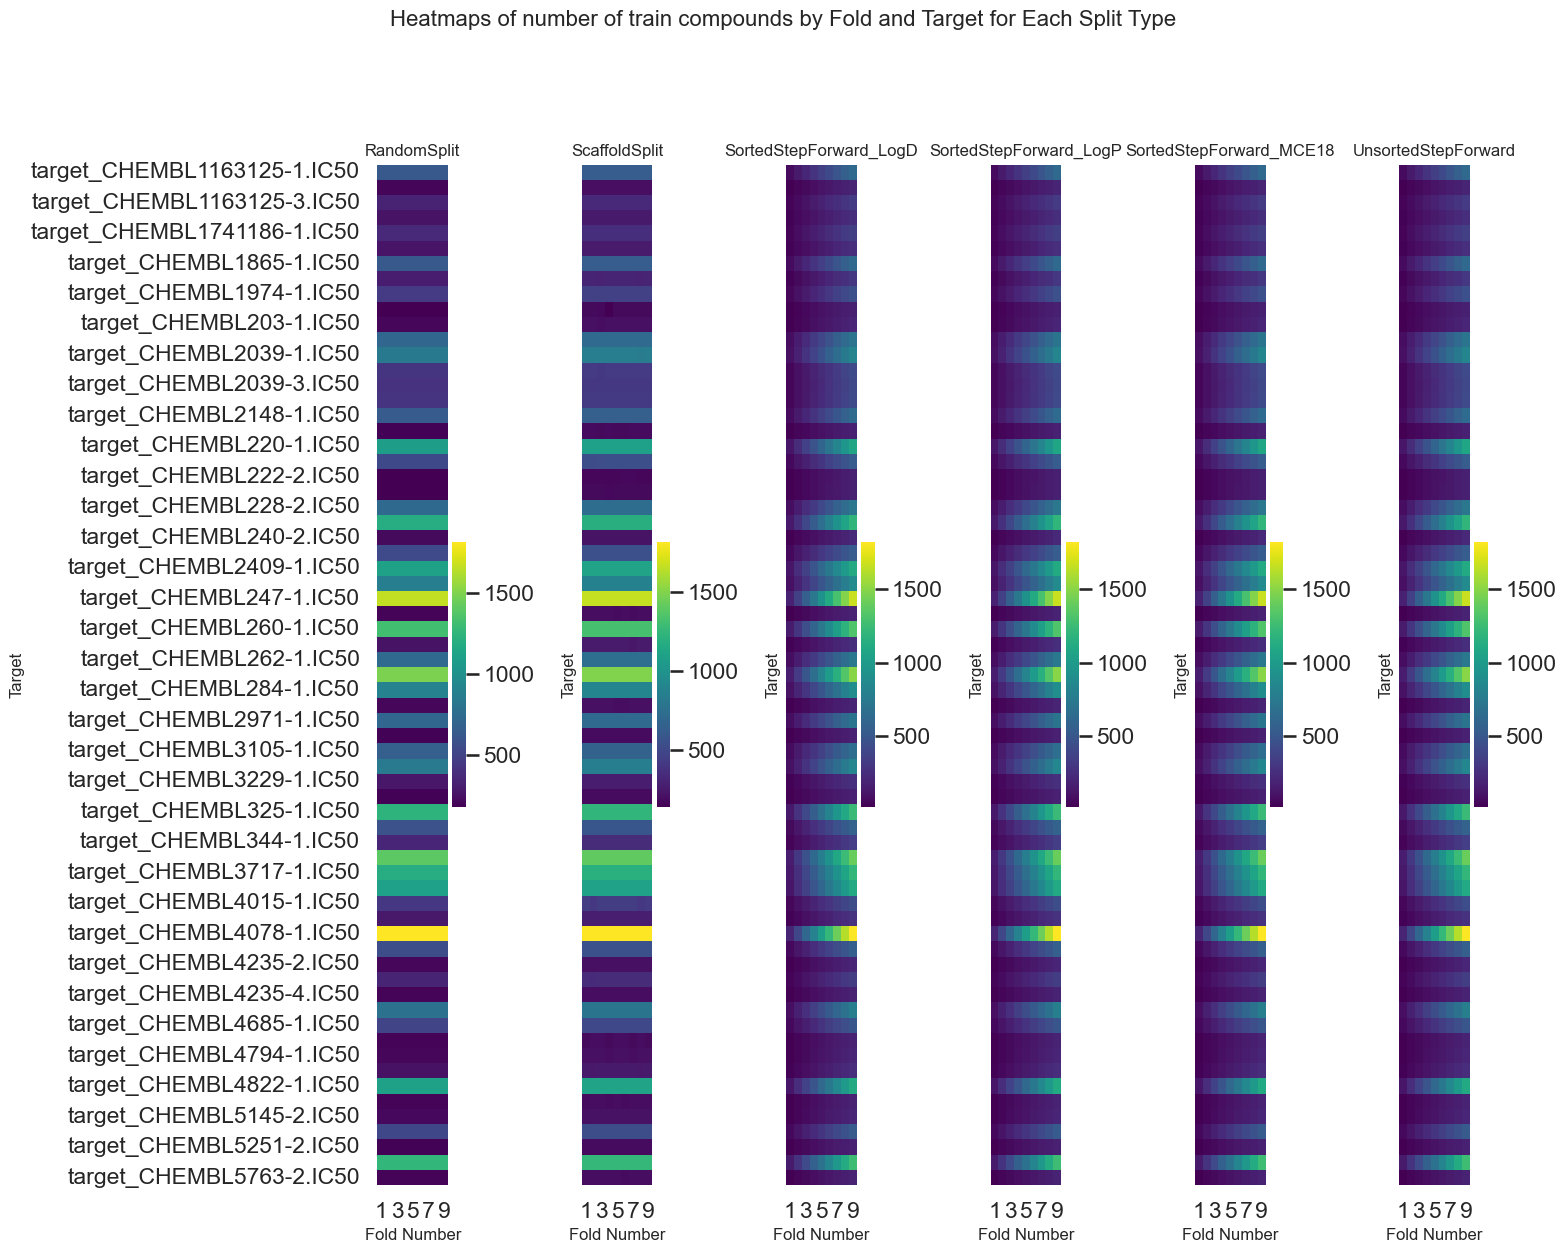

In [41]:
for metric in metric_cols:
    split_types = df['split_type'].unique()
    fig, axes = plt.subplots(1, len(split_types), figsize=(16, 12), sharey=True)

    for ax, st in zip(axes, split_types):
        # Create a pivot table: rows = targets, columns = fold_no; values = median metric
        pivot = df[df['split_type'] == st].groupby(['target', 'fold_no'])[metric].median().unstack()
        sns.heatmap(pivot, ax=ax, cmap='viridis', cbar=True)
        ax.set_title(st, fontsize=12)
        ax.set_xlabel('Fold Number', fontsize=12)
        ax.set_ylabel('Target', fontsize=12)

    plt.suptitle(f'Heatmaps of {metric} by Fold and Target for Each Split Type', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

In [19]:
split_types_of_interest = df['split_type'].unique()

In [36]:
def plot_per_fp(df, metric, title):
    # Filter dataset for relevant split types
    df_filtered = df[df["split_type"].isin(split_types_of_interest)]

    # Get unique fingerprints
    fingerprints = df_filtered["fingerprint"].unique()

    # Create a figure with 3 subplots (one for each fingerprint)
    fig, axes = plt.subplots(1, 3, figsize=(25, 20))
    fig.suptitle(title, fontsize=16)

    for ax, fingerprint in zip(axes, fingerprints):
        df_fp = df_filtered[df_filtered["fingerprint"] == fingerprint]

        # Aggregating number of novel compounds per fold per target
        pivot_table = df_fp.pivot_table(
            values=metric,
            index="target",
            columns="split_type",
            aggfunc="mean"
        )

        # Rank the values within each target
        ranked_pivot_table = pivot_table.rank(axis=1, method="min", ascending=False)

        # Plotting heatmap for each fingerprint
        sns.heatmap(
            ranked_pivot_table, annot=pivot_table, cmap="PiYG", fmt=".2f",
            linewidths=0.5, cbar_kws={"ticks": np.arange(1, len(split_types_of_interest) + 1)},
            ax=ax
        )

        ax.set_title(f"Fingerprint: {fingerprint}", fontsize=14)
        ax.set_xlabel("Split Type")
        ax.set_ylabel("Target")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"../benchmark/results/figures/{metric}_fp_heatmap.svg")
    plt.close()

In [37]:
def plot_aggregate(df, metric, title):
    # Filter dataset for relevant split types
    df_filtered = df[df["split_type"].isin(split_types_of_interest)]

    # Aggregating number of novel compounds per fold per target
    pivot_table = df_filtered.pivot_table(
        values=metric,
        index="target",
        columns="split_type",
        aggfunc="mean"  # Taking mean number of novel compounds per fold per target
    )

    # Rank the values within each target
    ranked_pivot_table = pivot_table.rank(axis=1, method="min", ascending=False)

    # Define a discrete colormap
    cmap = sns.color_palette("PiYG", as_cmap=True)  # Discrete color mapping

    # Plotting the heatmap with ranking colors
    plt.figure(figsize=(10, 30))
    sns.heatmap(ranked_pivot_table, annot=pivot_table, cmap=cmap, fmt=".2f", linewidths=0.5,
                cbar_kws={"ticks": np.arange(1, len(split_types_of_interest) + 1)})
    plt.title(title)
    plt.xlabel("Split Type")
    plt.ylabel("Target")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.savefig(f"../benchmark/results/figures/{metric}_heatmap.svg")
    plt.close()

In [38]:
metrics = ['r2', 'rmse',
           'novelty_err', 'discovery_yield', 'number of discovery compounds',
           'number of discovery compounds within error range',
           'number of novel compounds', 'number of novel discovery compounds',
           'number of novel discovery compounds within error range',
           'number of test compounds', 'number of train compounds']

In [39]:
metric2title = {"r2": "Ranked $r^2$ per Fold per Target",
                "rmse": "Ranked RMSE per Fold per Target",
                "novelty_err": "Ranked Novelty Error per Fold per Target",
                "discovery_yield": "Ranked Discovery Yield per Fold per Target",
                "number of discovery compounds": "Ranked Number of Discovery compounds per Fold per Target",
                "number of discovery compounds within error range": "Ranked Number of Discovery compounds within +/-0.5 log units of true pIC50 per Fold per Target",
                "number of novel compounds": "Ranked Number of Novel Compounds per Fold per Target",
                "number of novel discovery compounds": "Ranked Number of Novel Discovery Compounds per Fold per Target",
                "number of novel discovery compounds within error range": "Ranked Number of Novel Discovery compounds within +/-0.5 log units of true pIC50  per Fold per Target",
                "number of test compounds": "Ranked Number of Test Compounds per Fold per Target",
                "number of train compounds": "Ranked Number of Train Compounds per Fold per Target"}

In [40]:
for metric in metrics:
    title = metric2title[metric]
    plot_per_fp(df, metric, title)
    plot_aggregate(df, metric, title)

In [41]:
def box_and_whisker(data, title, ylabel, xticklabels):
    """
    Create a box-and-whisker plot with significance bars, larger figure size, and rotated x labels.
    """
    fig, ax = plt.subplots(figsize=(8, 12))  # Increased figure size for better clarity
    bp = ax.boxplot(data, widths=0.6, patch_artist=True)

    # Graph title
    ax.set_title(title, fontsize=16)
    # Label y-axis
    ax.set_ylabel(ylabel, fontsize=14)
    # Label x-axis ticks
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=12)  # Rotated x labels for better visibility
    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0)
    # Show x-axis minor ticks
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks, minor=True)
    # Clean up the appearance
    ax.tick_params(axis='x', which='minor', length=3, width=1)

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    colors = sns.color_palette('pastel', n_colors=len(data))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Colour of the median lines
    plt.setp(bp['medians'], color='k', linewidth=2)

    # Check for statistical significance
    significant_combinations = []
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]

    for c in combinations:
        data1 = data[c[0] - 1]
        data2 = data[c[1] - 1]
        # Mann-Whitney U test (non-parametric test)
        U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        if p < 0.05:
            significant_combinations.append([c, p])

    # Get info about y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom

    # Significance bars
    for i, significant_combination in enumerate(significant_combinations):
        x1, x2 = significant_combination[0]
        level = len(significant_combinations) - i
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.02)
        plt.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k')

        # Significance level annotation
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        else:
            sig_symbol = ''

        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', fontsize=14, fontweight='bold', c='k')

    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top + 0.05 * yrange)

    # # Annotate sample size below each box
    # for i, dataset in enumerate(data):
    #     sample_size = len(dataset)
    #     ax.text(i + 1, bottom - (yrange * 0.05), fr'n = {sample_size}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.256e+07
ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.168e-22 U_stat=1.314e+07
SortedStepForward_LogD vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.541e-23 U_stat=1.636e+07
SortedStepForward_LogP vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:2.822e-167 U_stat=1.923e+07
SortedStepForward_MCE18 vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=6.218e+06
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.143e+07
SortedStepForward_LogD vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:3.866e-293 U_stat=2.

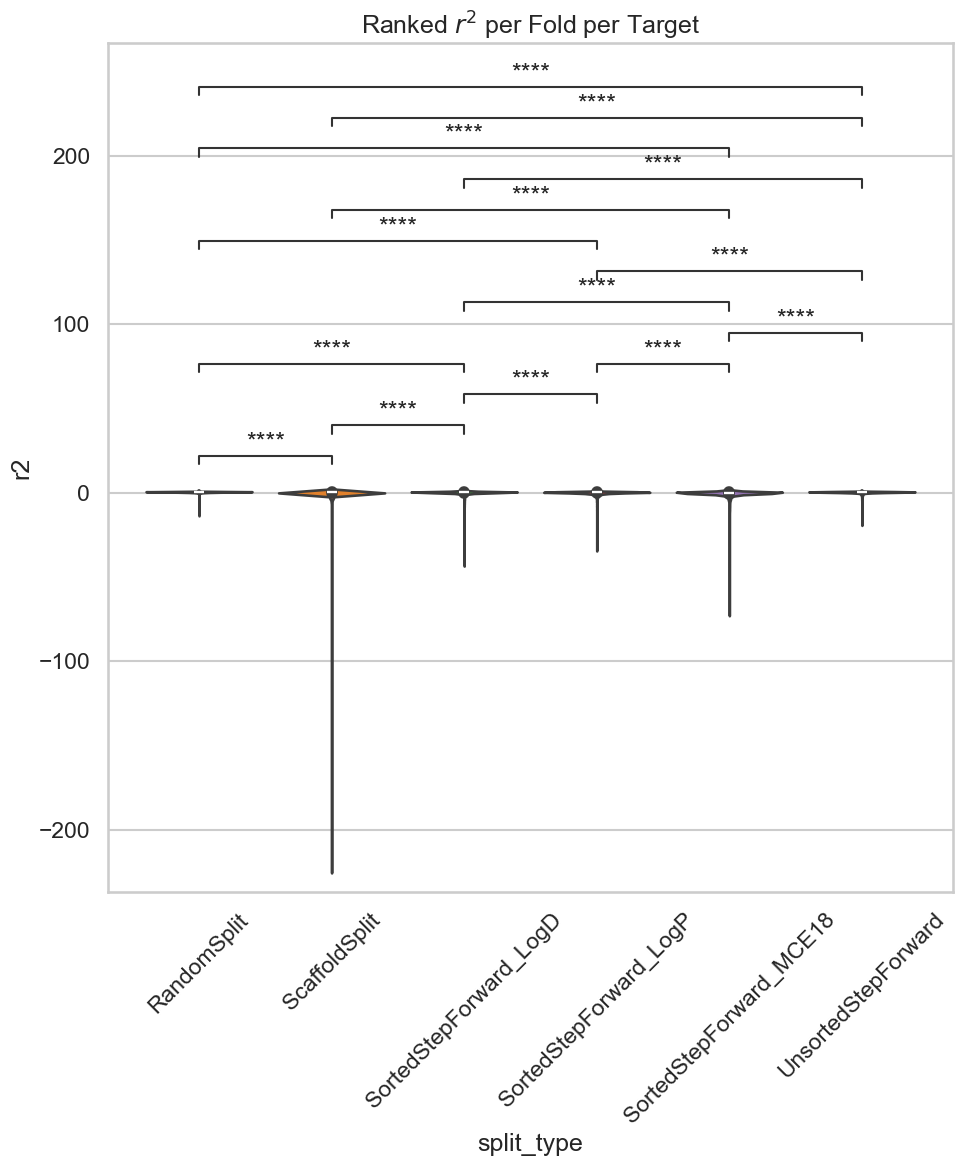

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:2.029e-236 U_stat=9.367e+06
ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.489e-04 U_stat=1.415e+07
SortedStepForward_LogD vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:6.311e-09 U_stat=1.378e+07
SortedStepForward_LogP vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:2.483e-59 U_stat=1.207e+07
SortedStepForward_MCE18 vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:1.777e-254 U_stat=2.029e+07
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=8.572e+06
ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.098e-19 U_stat=1.324e+07
So

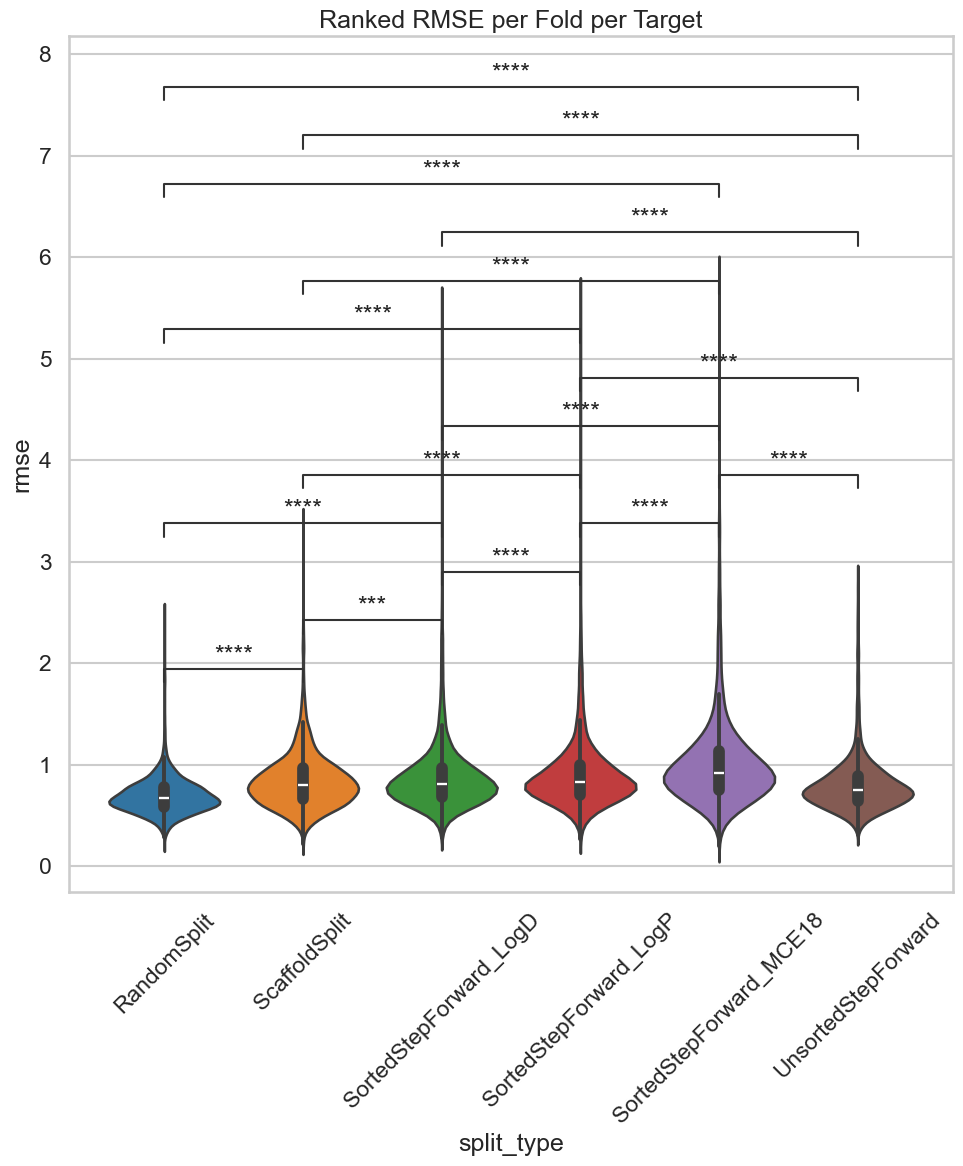

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:1.006e-04 U_stat=6.736e+06
ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.040e-22 U_stat=7.492e+06
SortedStepForward_LogD vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.474e-04 U_stat=1.012e+07
SortedStepForward_LogP vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:1.321e-04 U_stat=1.079e+07
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.543e-05 U_stat=7.136e+06
ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.399e-40 U_stat=7.461e+06
SortedStepForward_LogP vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:4.382e-08 U_stat=1.030e+07
Rando

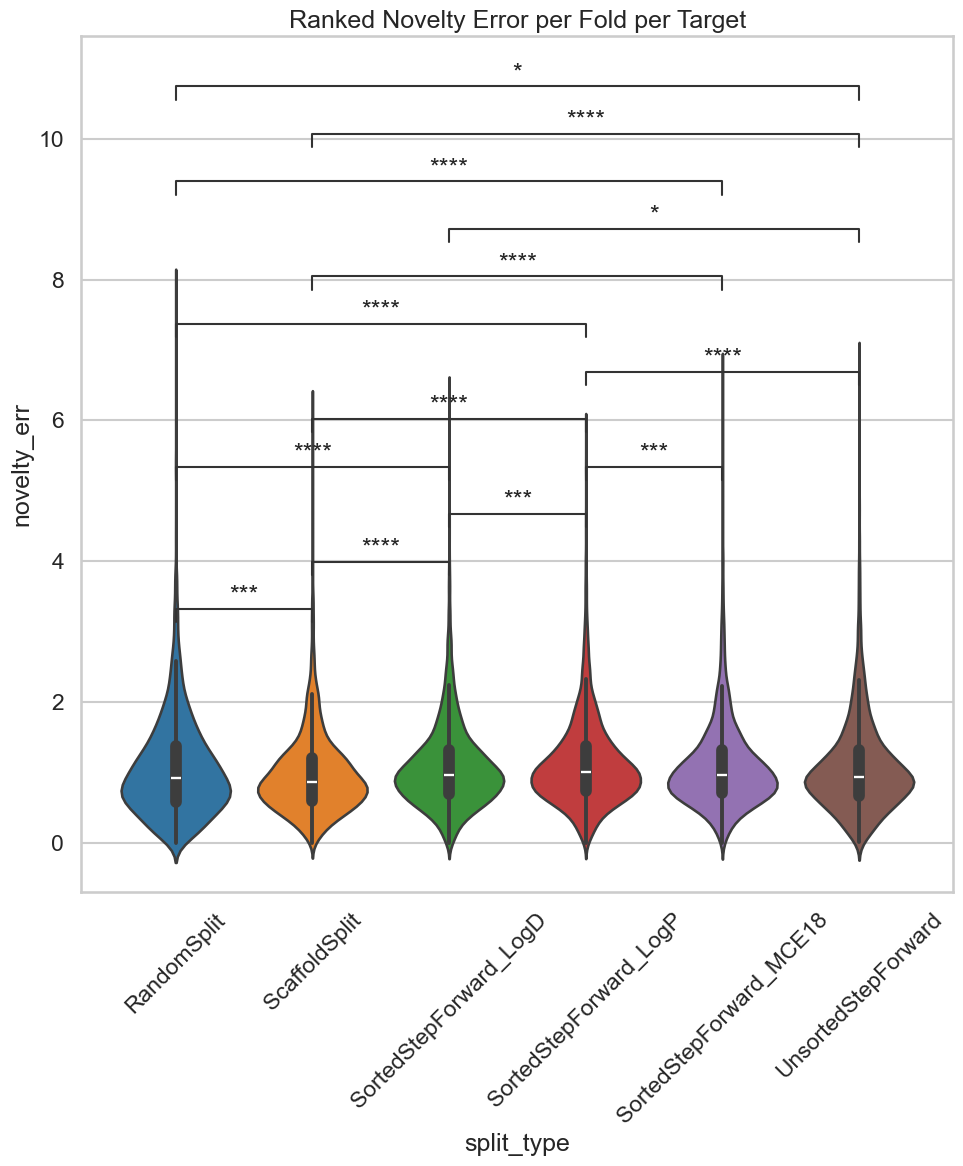

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:3.249e-295 U_stat=2.072e+07
ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.075e-08 U_stat=1.384e+07
SortedStepForward_LogD vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.023e-02 U_stat=1.435e+07
SortedStepForward_LogP vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:6.618e-133 U_stat=1.873e+07
SortedStepForward_MCE18 vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:1.646e-273 U_stat=8.960e+06
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:7.309e-251 U_stat=2.025e+07
ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:5.608e-14 U_stat=1.350e+07


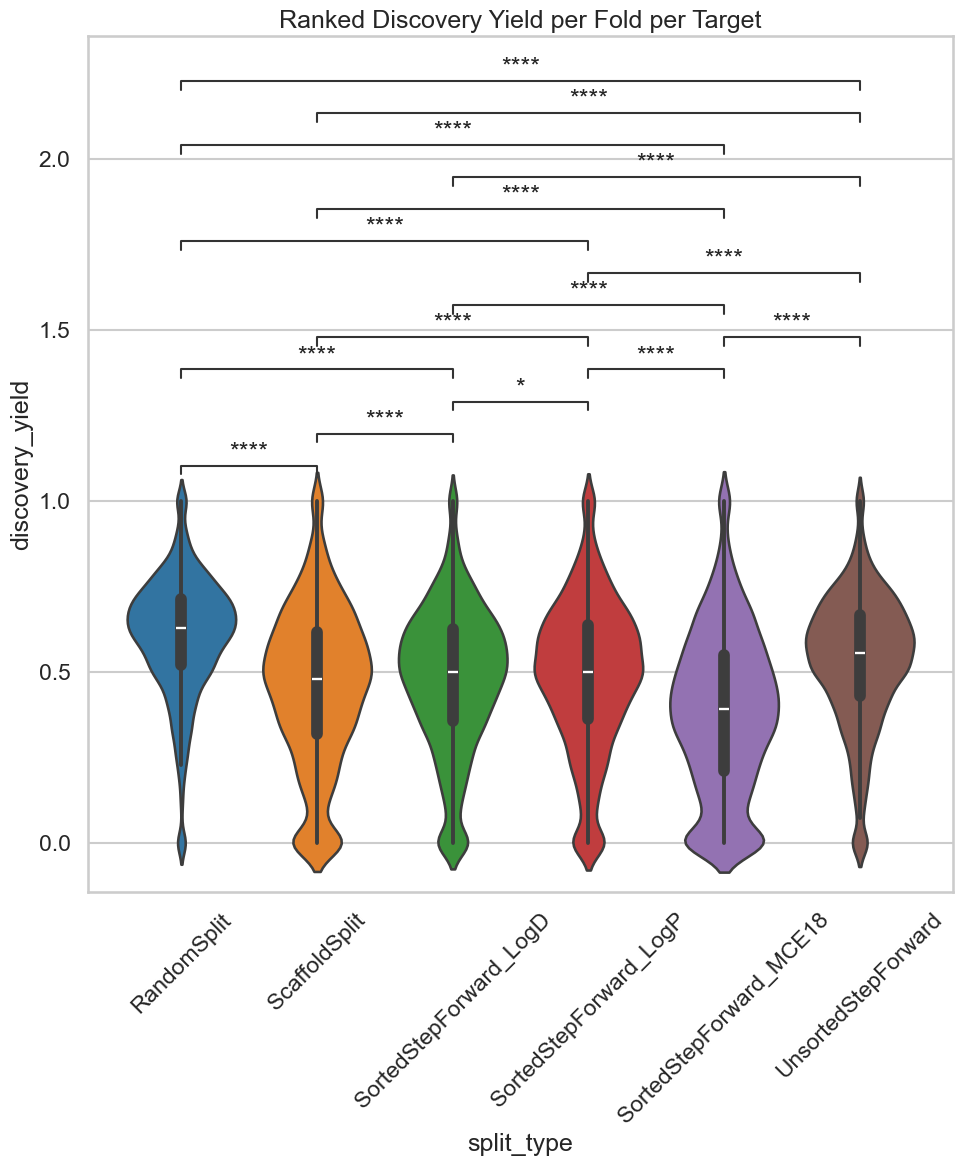

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.703e-03 U_stat=1.524e+07
RandomSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.149e-02 U_stat=1.514e+07


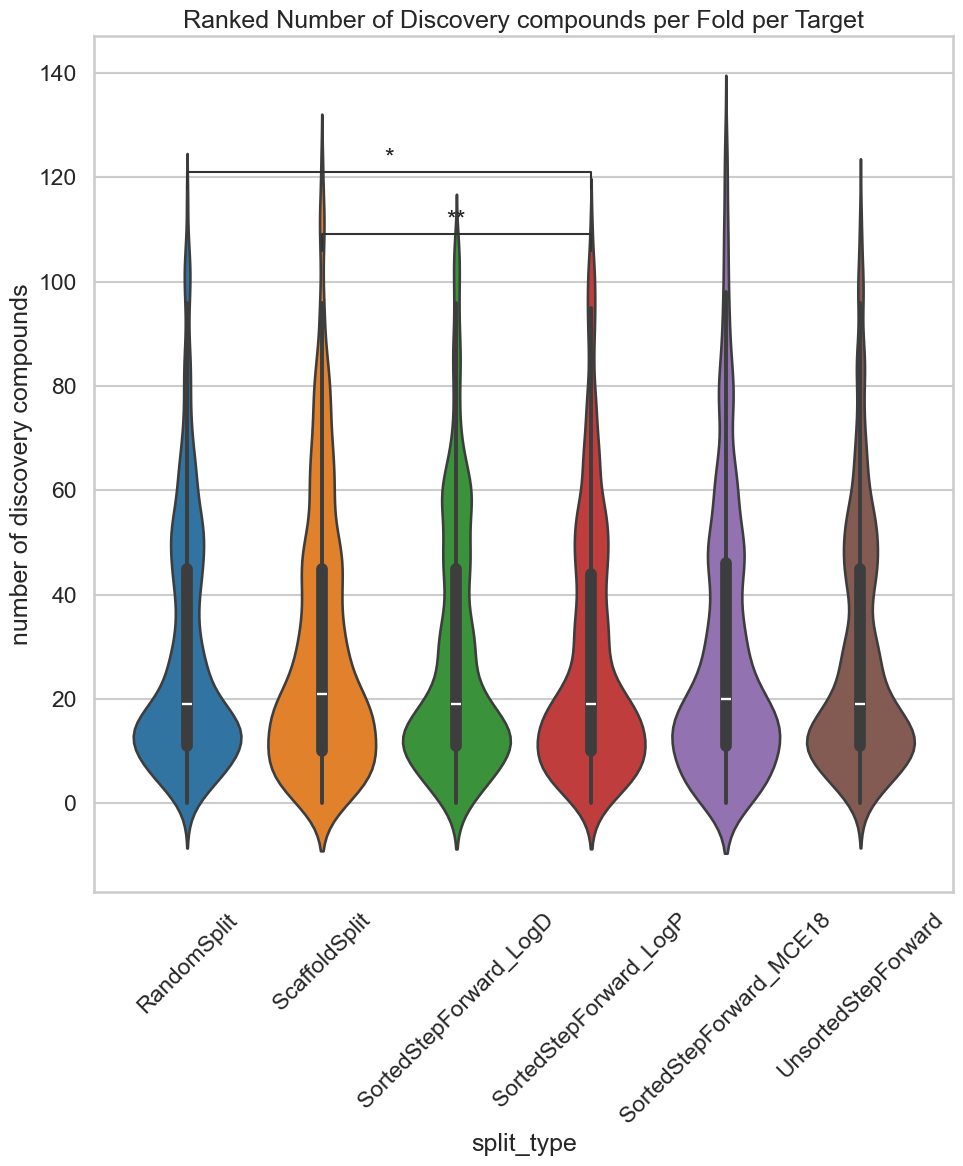

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:5.777e-40 U_stat=1.688e+07
SortedStepForward_LogP vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:3.301e-26 U_stat=1.645e+07
SortedStepForward_MCE18 vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:4.642e-62 U_stat=1.201e+07
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.609e-36 U_stat=1.677e+07
SortedStepForward_LogD vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:5.050e-31 U_stat=1.661e+07
SortedStepForward_LogP vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:7.780e-10 U_stat=1.372e+07
RandomSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.663e-42 U_stat=1.695e+07

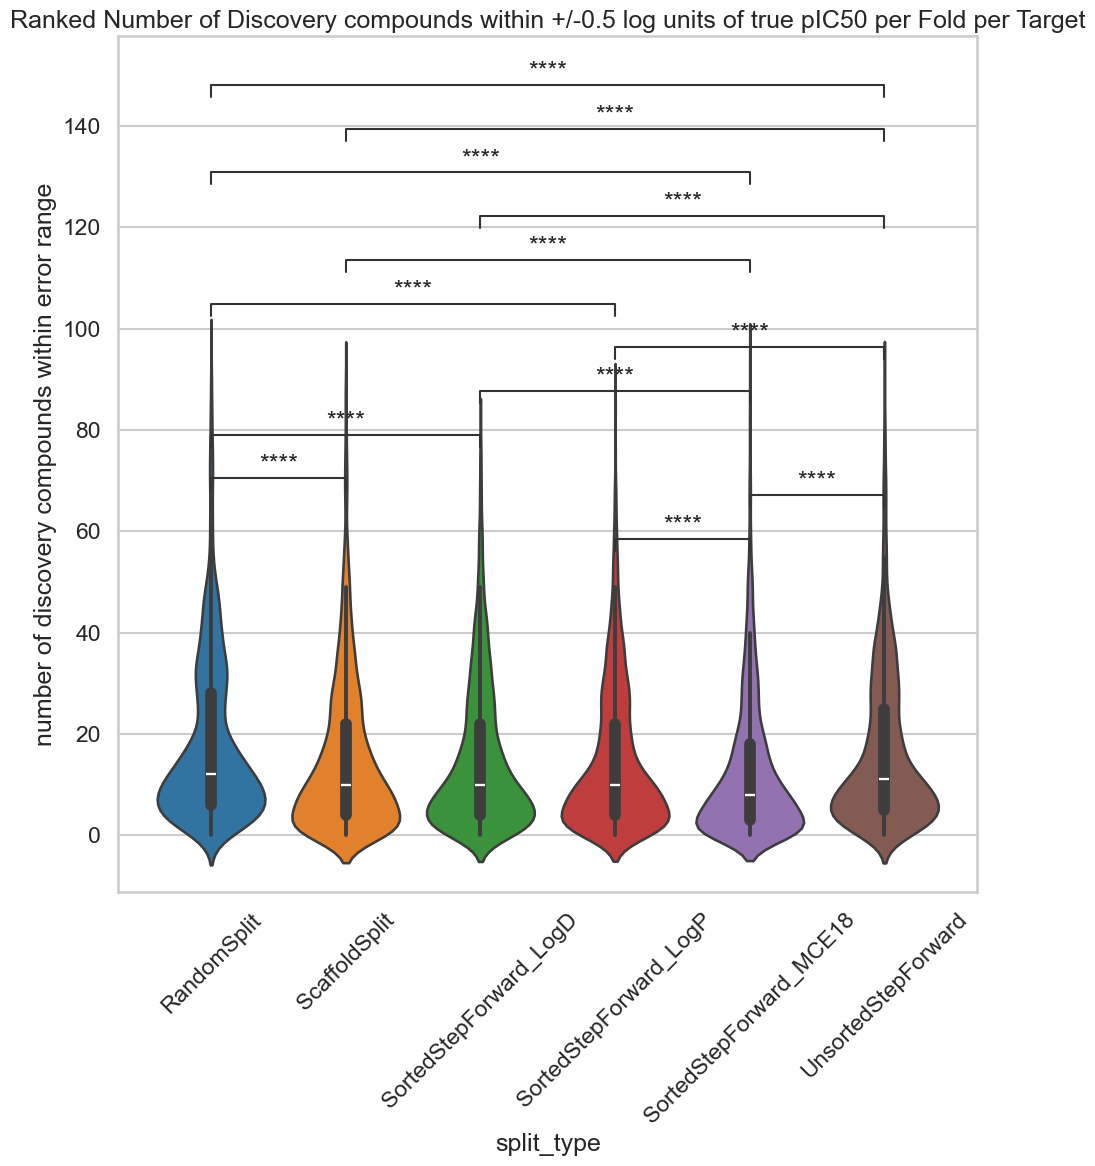

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:2.762e-170 U_stat=1.030e+07
ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.891e-23 U_stat=1.311e+07
SortedStepForward_LogD vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.494e-15 U_stat=1.343e+07
SortedStepForward_LogP vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:1.055e-40 U_stat=1.255e+07
SortedStepForward_MCE18 vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:1.887e-253 U_stat=2.023e+07
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=7.516e+06
ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.583e-61 U_stat=1.204e+07
So

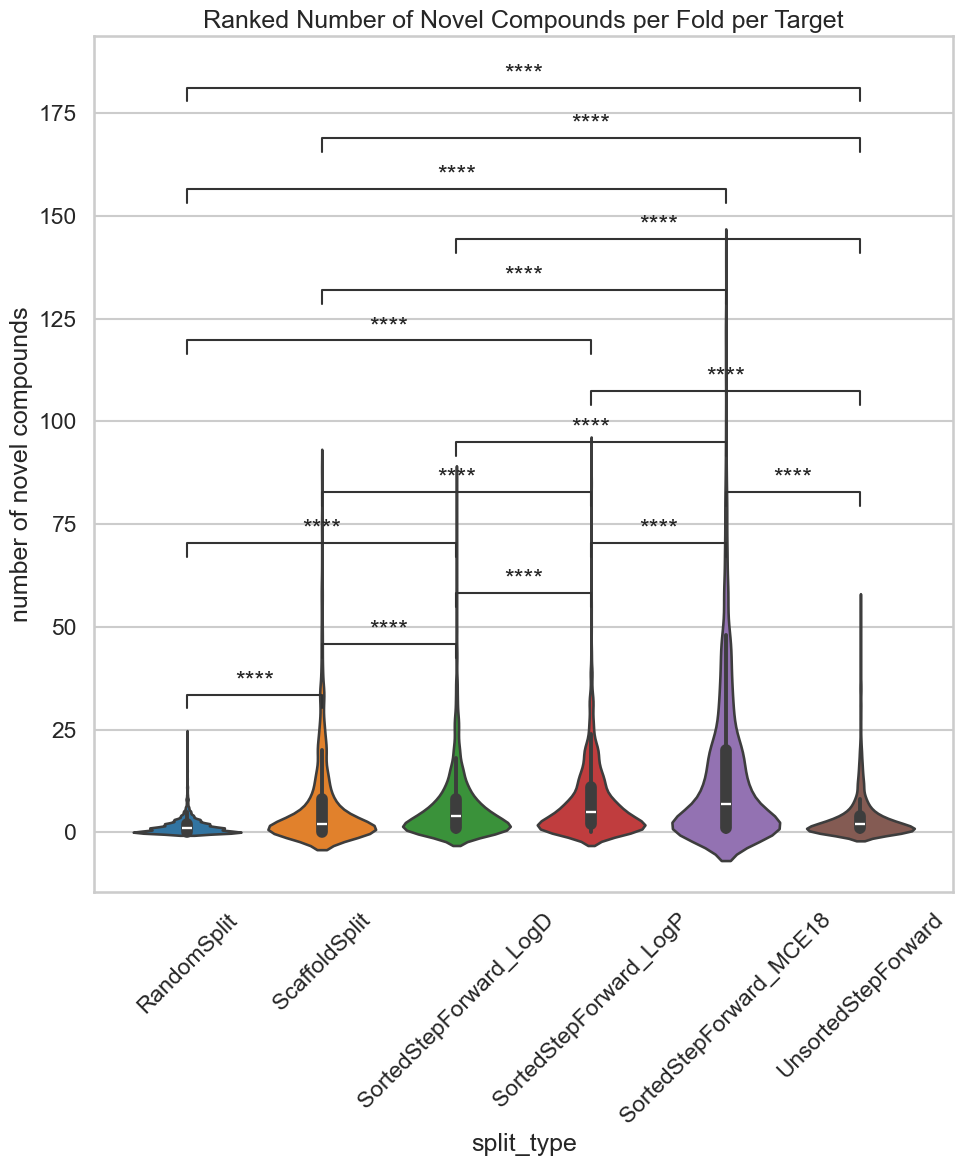

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:1.573e-99 U_stat=1.168e+07
ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.010e-29 U_stat=1.300e+07
SortedStepForward_LogD vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.779e-09 U_stat=1.379e+07
SortedStepForward_LogP vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:2.821e-40 U_stat=1.261e+07
SortedStepForward_MCE18 vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:1.418e-234 U_stat=1.981e+07
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.414e-277 U_stat=9.418e+06
ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:6.573e-61 U_stat=1.217e+07
So

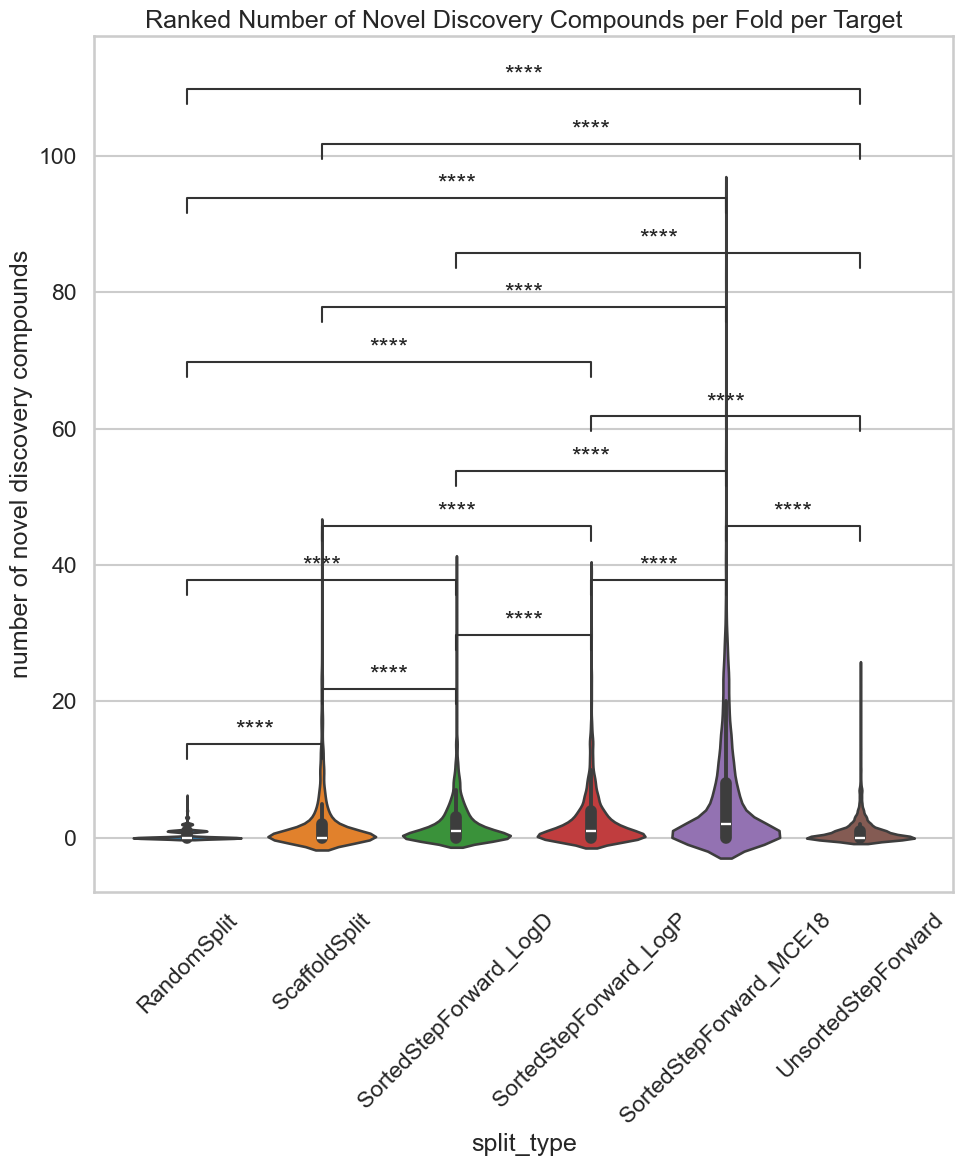

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:6.197e-74 U_stat=1.290e+07
ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.406e-10 U_stat=1.395e+07
SortedStepForward_LogD vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.586e-04 U_stat=1.424e+07
SortedStepForward_LogP vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:1.461e-20 U_stat=1.347e+07
SortedStepForward_MCE18 vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:8.927e-116 U_stat=1.764e+07
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.321e-137 U_stat=1.202e+07
ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.745e-23 U_stat=1.350e+07
So

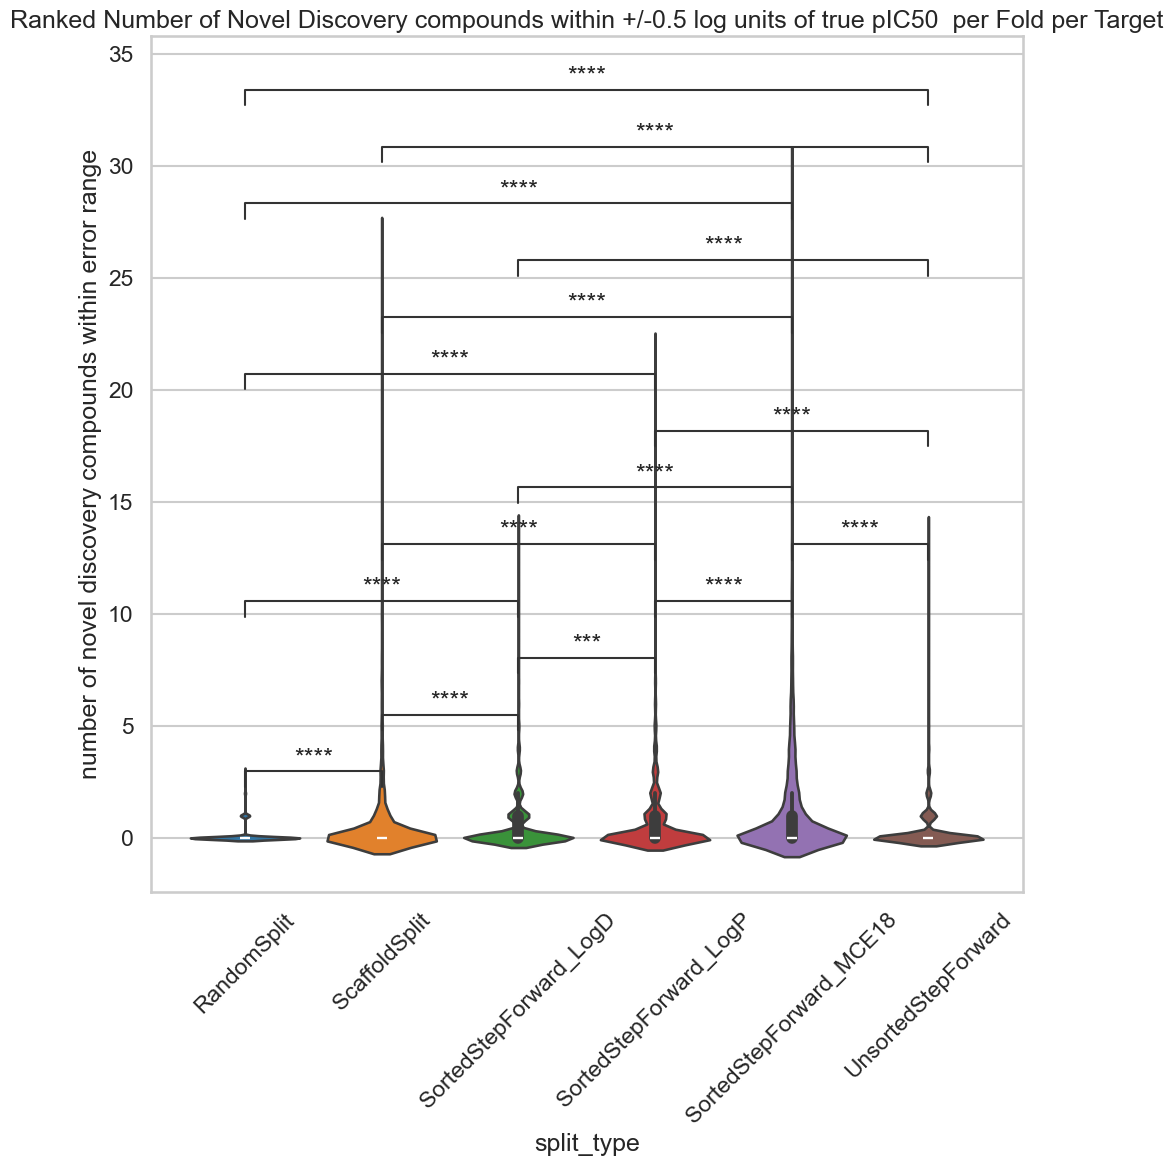

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Mann-Whitney-Wilcoxon test two-sided, P_val:1.983e-03 U_stat=1.422e+07
ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:9.808e-08 U_stat=1.560e+07
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.095e-03 U_stat=1.516e+07
ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:9.808e-08 U_stat=1.560e+07
RandomSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:8.095e-03 U_stat=1.516e+07
ScaffoldSplit vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:9.808e-08 U_stat=1.560e+07
RandomSplit vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:8.095e-03 U_stat=1.516e+07
ScaffoldSplit vs. UnsortedStepFo

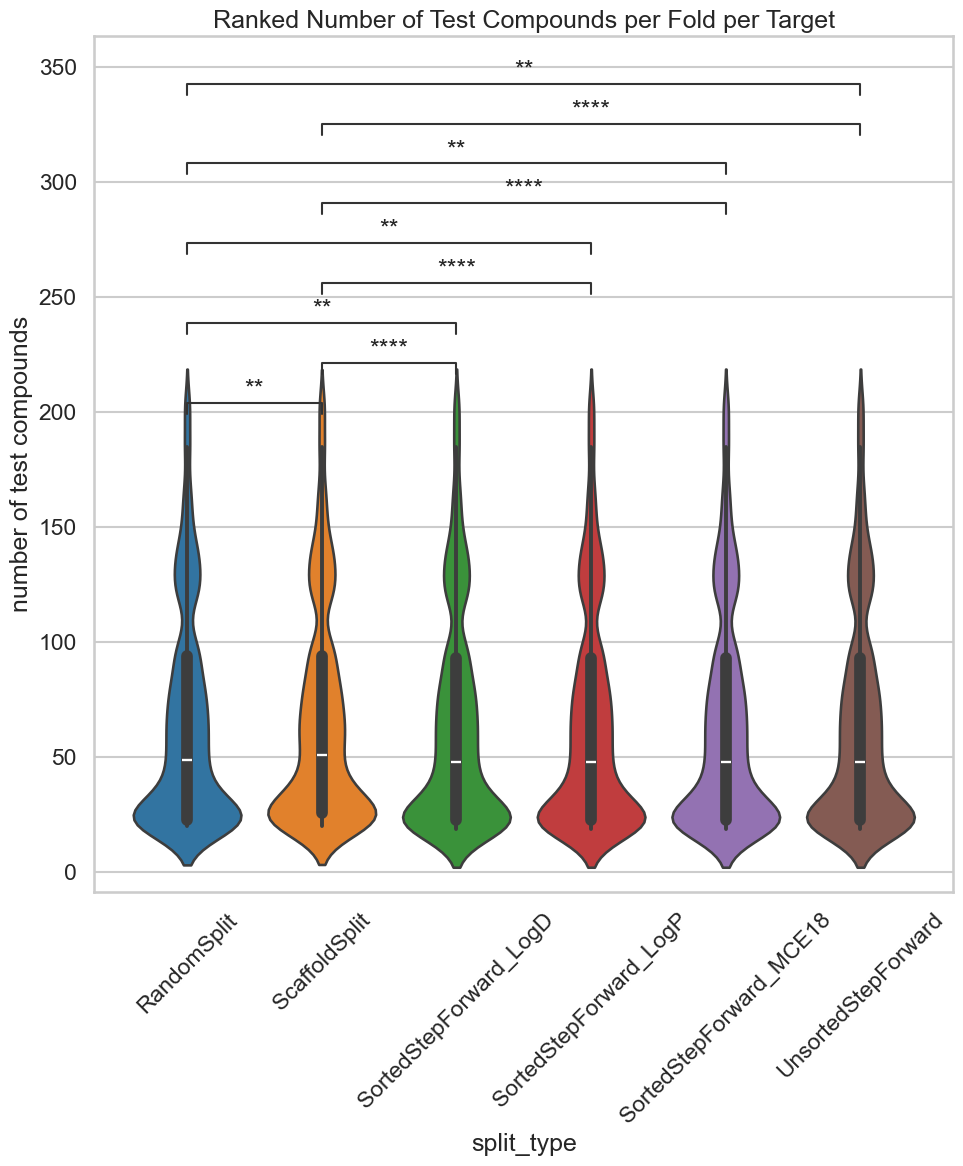

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ScaffoldSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.139e+07
RandomSplit vs. SortedStepForward_LogD: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.144e+07
ScaffoldSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.139e+07
RandomSplit vs. SortedStepForward_LogP: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.144e+07
ScaffoldSplit vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.139e+07
RandomSplit vs. SortedStepForward_MCE18: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.144e+07
ScaffoldSplit vs. UnsortedStepForward: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.139e+07
RandomSplit vs. Unsorted

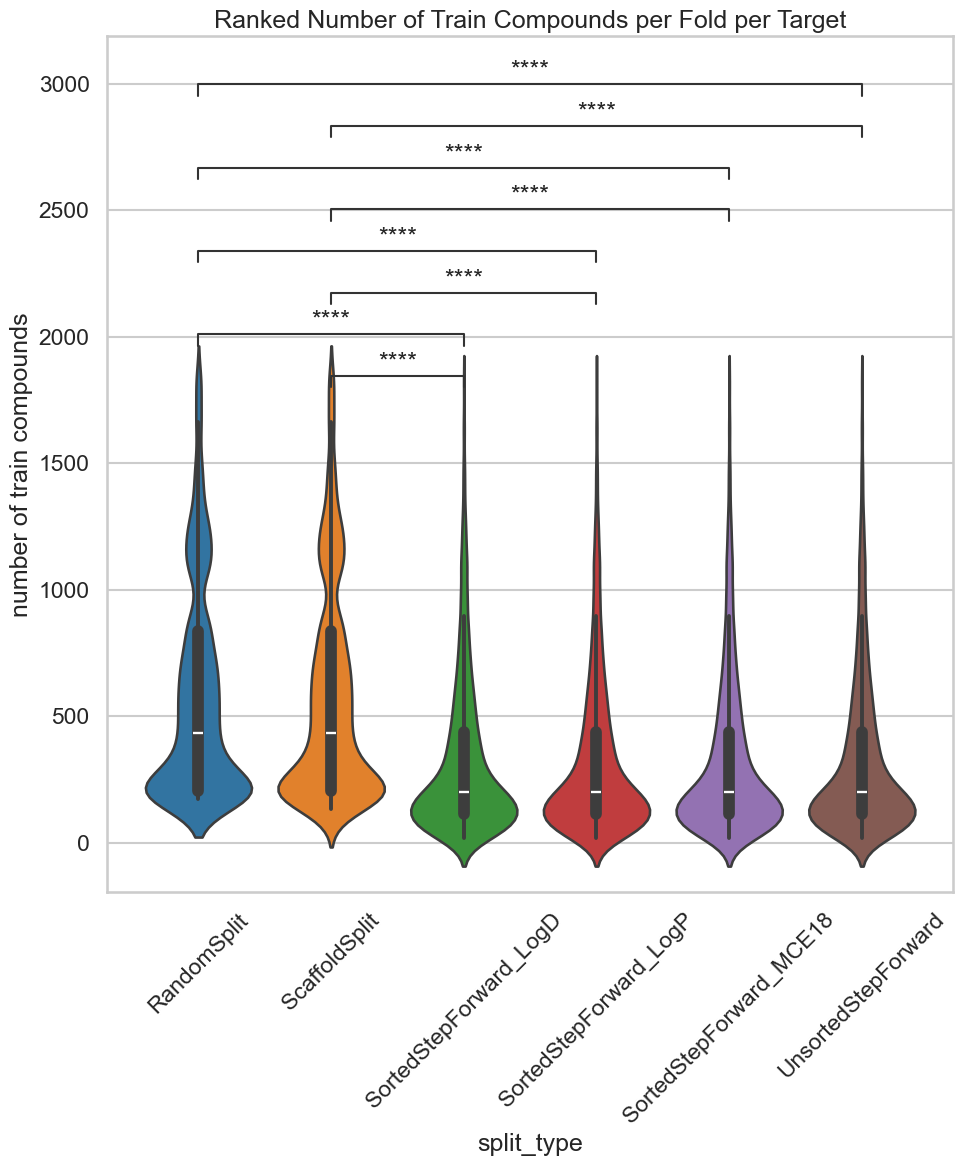

In [42]:
split_types = df["split_type"].unique()
pairs = list(combinations(split_types, 2))  # Generate all pairwise comparisons

for metric in metrics:
    title = metric2title.get(metric, metric)

    plt.figure(figsize=(10, 12))
    ax = sns.violinplot(data=df, x="split_type", y=metric, hue="split_type", dodge=False)

    # Annotate p-values using statannotations
    annotator = Annotator(ax, pairs, data=df, x="split_type", y=metric)
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside",
                        hide_non_significant=True)  # Using independent t-test
    annotator.apply_and_annotate()

    ax.set_title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../benchmark/results/figures/{metric}_Mann-Whitney.svg')
    plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:0.000e+00 W=-5.888e+01
ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:1.430e-22 W=9.798e+00
SortedStepForward_LogD vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:9.016e-24 W=-1.008e+01
SortedStepForward_LogP vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:9.335e-180 W=-2.914e+01
SortedStepForward_MCE18 vs. UnsortedStepForward: Brunner-Munzel test, P_val:0.000e+00 W=6.594e+01
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:0.000e+00 W=-4.741e+01
SortedStepForward_LogD vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:0.000e+00 W=-4.062e+01
SortedStepForward_LogP vs. UnsortedStepForward: Brunner-Munzel test, P_val:7.067e-194 W=3.032e+01
RandomSplit vs. SortedStepForward_LogP: Brun

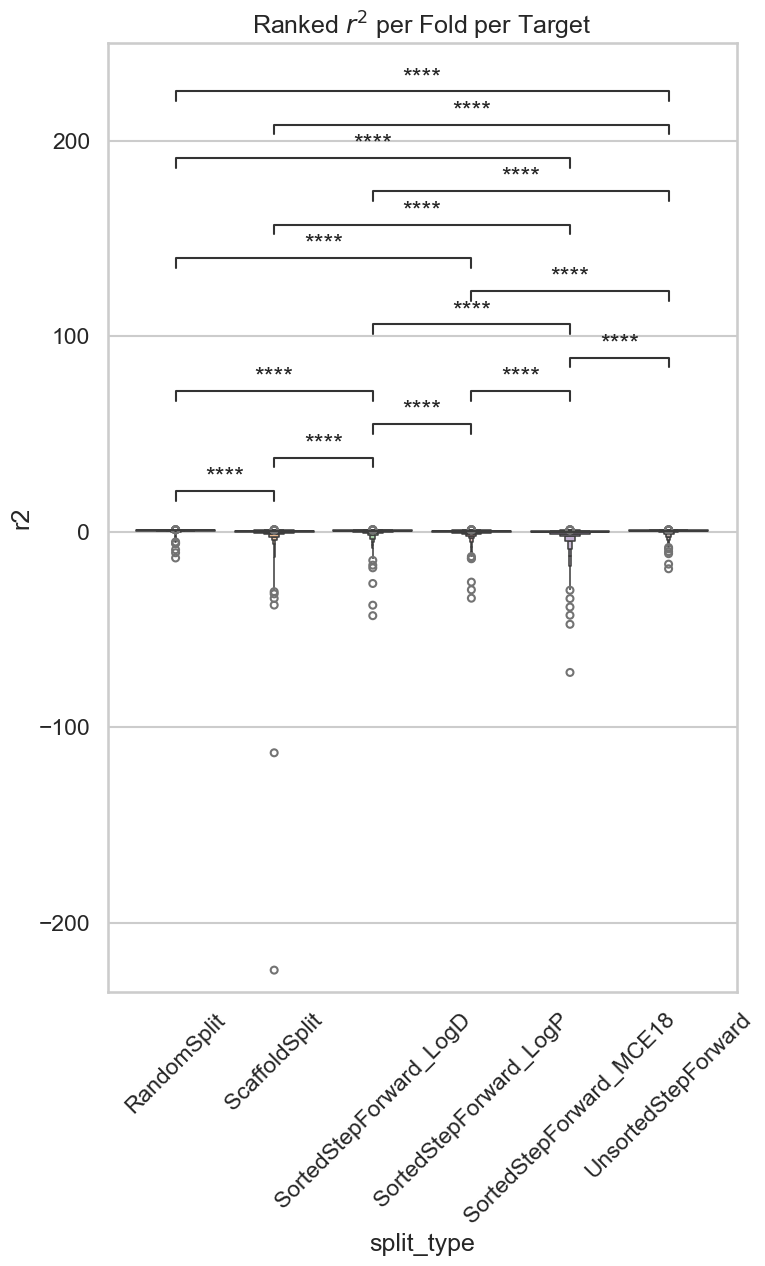

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:1.535e-261 W=3.559e+01
ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:4.478e-04 W=3.511e+00
SortedStepForward_LogD vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:5.955e-09 W=5.823e+00
SortedStepForward_LogP vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:1.727e-60 W=1.651e+01
SortedStepForward_MCE18 vs. UnsortedStepForward: Brunner-Munzel test, P_val:2.826e-283 W=-3.710e+01
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:0.000e+00 W=4.243e+01
ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:7.609e-20 W=9.136e+00
SortedStepForward_LogD vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:3.812e-106 W=2.213e+01
SortedStepForward_LogP vs. UnsortedStepForward: Brunn

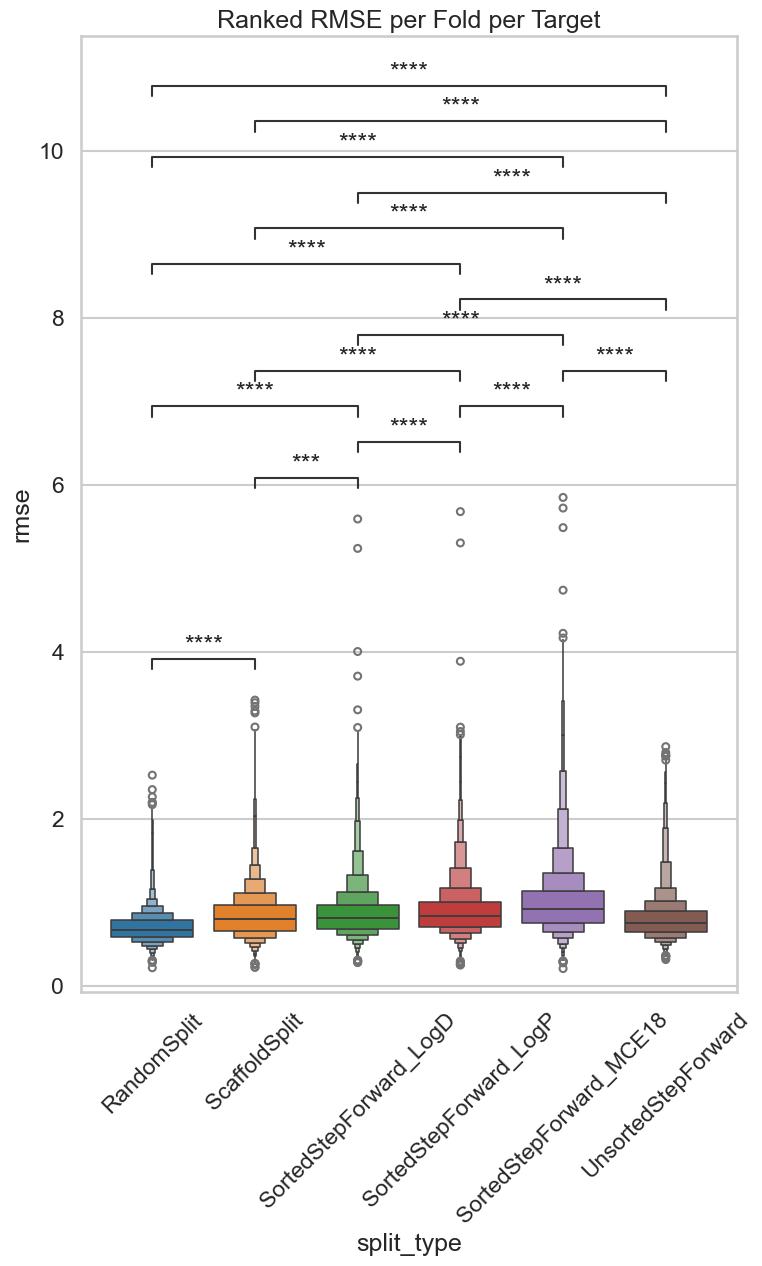

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:1.192e-04 W=-3.850e+00
ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:6.827e-23 W=9.881e+00
SortedStepForward_LogD vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:2.450e-04 W=3.669e+00
SortedStepForward_LogP vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:1.306e-04 W=-3.827e+00
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:3.814e-05 W=4.121e+00
ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:2.949e-41 W=1.353e+01
SortedStepForward_LogP vs. UnsortedStepForward: Brunner-Munzel test, P_val:4.679e-08 W=-5.468e+00
RandomSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:1.515e-12 W=7.088e+00
ScaffoldSplit vs. SortedStepForward_MCE18: Brunner-Munzel test, P_v

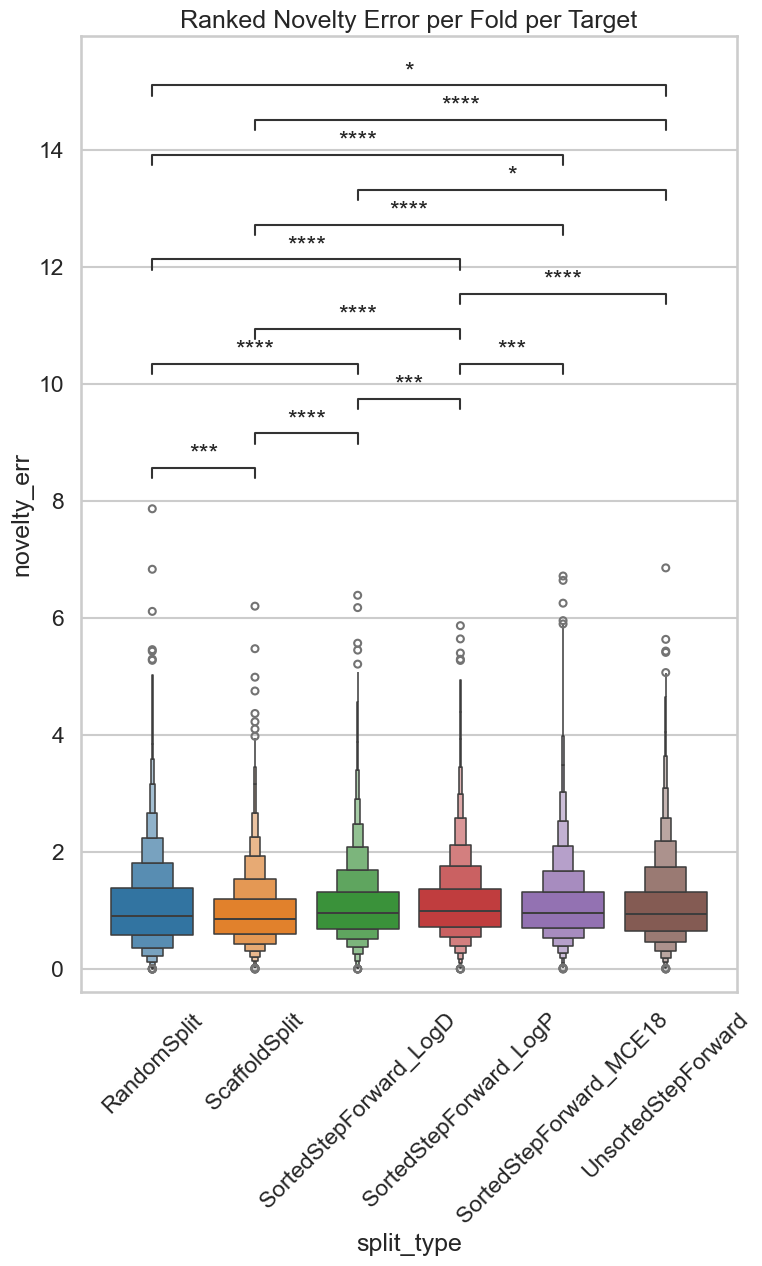

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:0.000e+00 W=-4.059e+01
ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:5.033e-08 W=5.454e+00
SortedStepForward_LogD vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:2.023e-02 W=2.322e+00
SortedStepForward_LogP vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:1.969e-140 W=-2.561e+01
SortedStepForward_MCE18 vs. UnsortedStepForward: Brunner-Munzel test, P_val:6.677e-306 W=3.868e+01
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:5.774e-281 W=-3.692e+01
ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:4.848e-14 W=7.546e+00
SortedStepForward_LogD vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:8.853e-123 W=-2.387e+01
SortedStepForward_LogP vs. UnsortedStepForward: B

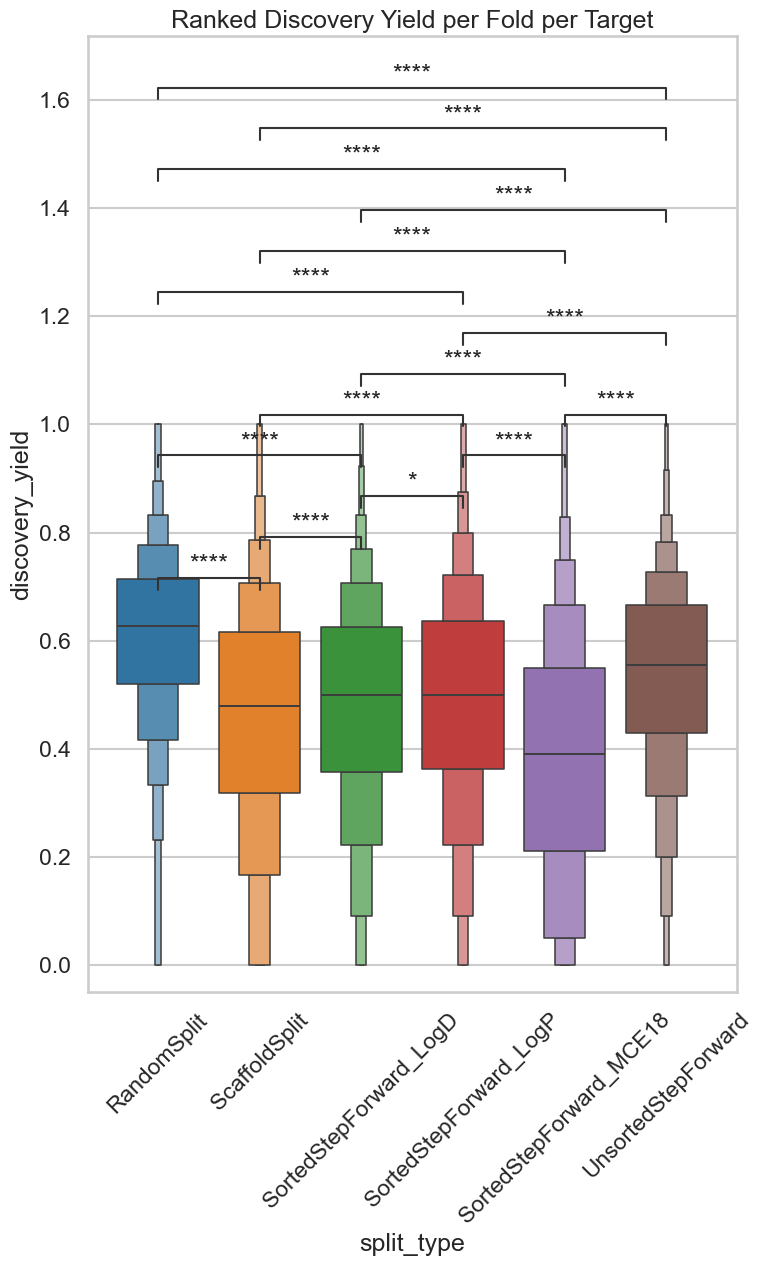

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:1.715e-03 W=-3.136e+00
RandomSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:1.156e-02 W=-2.526e+00


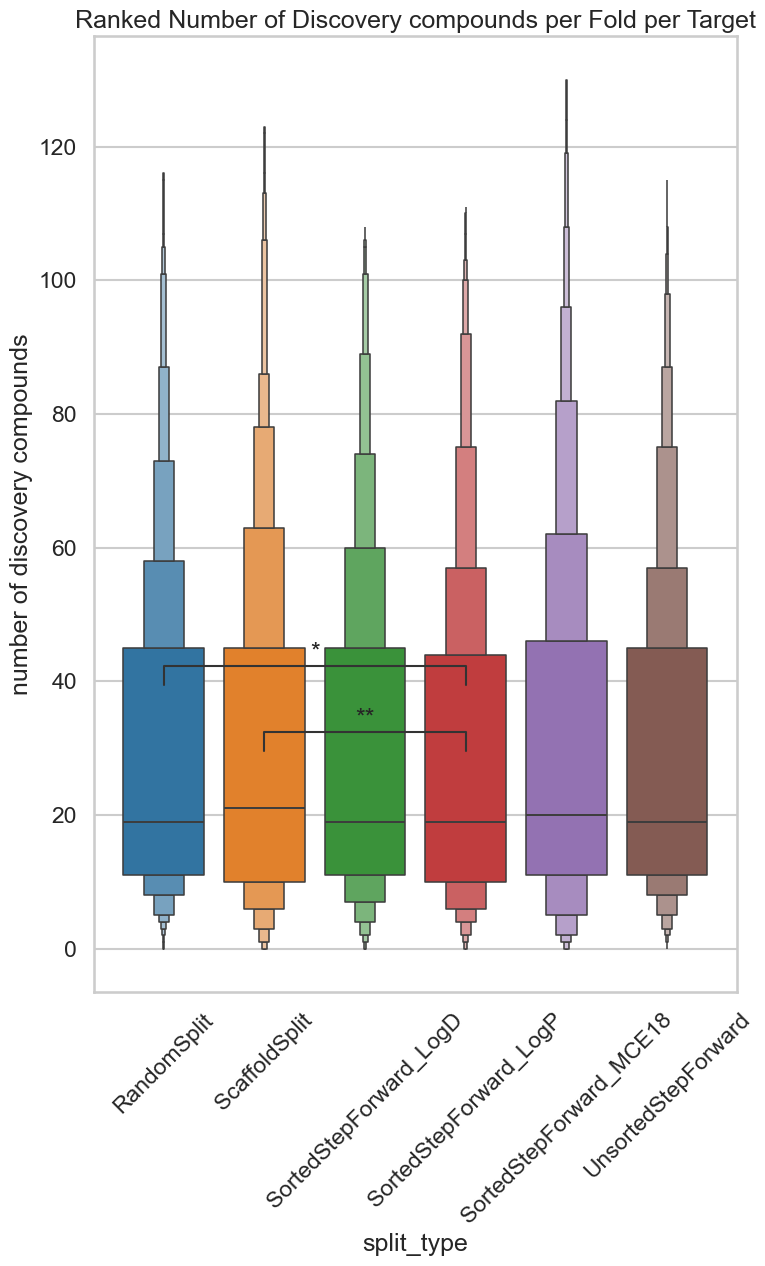

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:1.119e-40 W=-1.341e+01
SortedStepForward_LogP vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:1.655e-26 W=-1.068e+01
SortedStepForward_MCE18 vs. UnsortedStepForward: Brunner-Munzel test, P_val:6.411e-64 W=1.699e+01
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:1.194e-36 W=-1.269e+01
SortedStepForward_LogD vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:1.860e-31 W=-1.171e+01
SortedStepForward_LogP vs. UnsortedStepForward: Brunner-Munzel test, P_val:7.215e-10 W=6.167e+00
RandomSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:5.523e-43 W=-1.381e+01
ScaffoldSplit vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:4.036e-24 W=-1.015e+01
SortedStepForward_LogD vs. UnsortedStepForward: Brunner

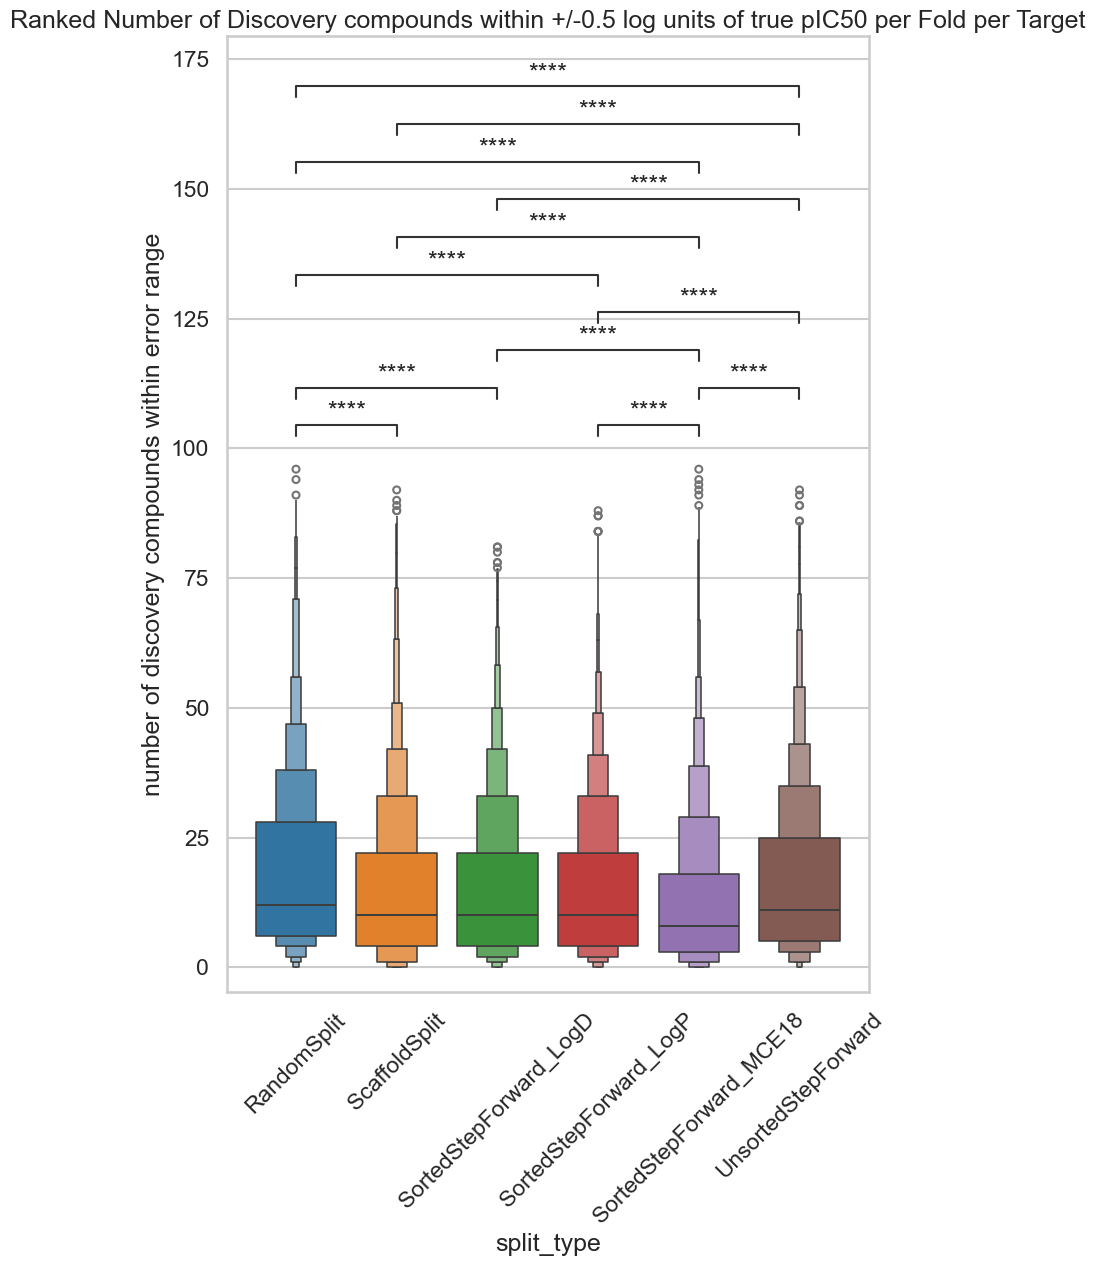

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:5.997e-175 W=2.889e+01
ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:3.361e-23 W=9.946e+00
SortedStepForward_LogD vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:1.219e-15 W=8.015e+00
SortedStepForward_LogP vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:9.670e-40 W=1.326e+01
SortedStepForward_MCE18 vs. UnsortedStepForward: Brunner-Munzel test, P_val:7.888e-266 W=-3.616e+01
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:0.000e+00 W=5.241e+01
ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:9.330e-62 W=1.670e+01
SortedStepForward_LogD vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:5.295e-81 W=1.926e+01
SortedStepForward_LogP vs. UnsortedStepForward: Brunne

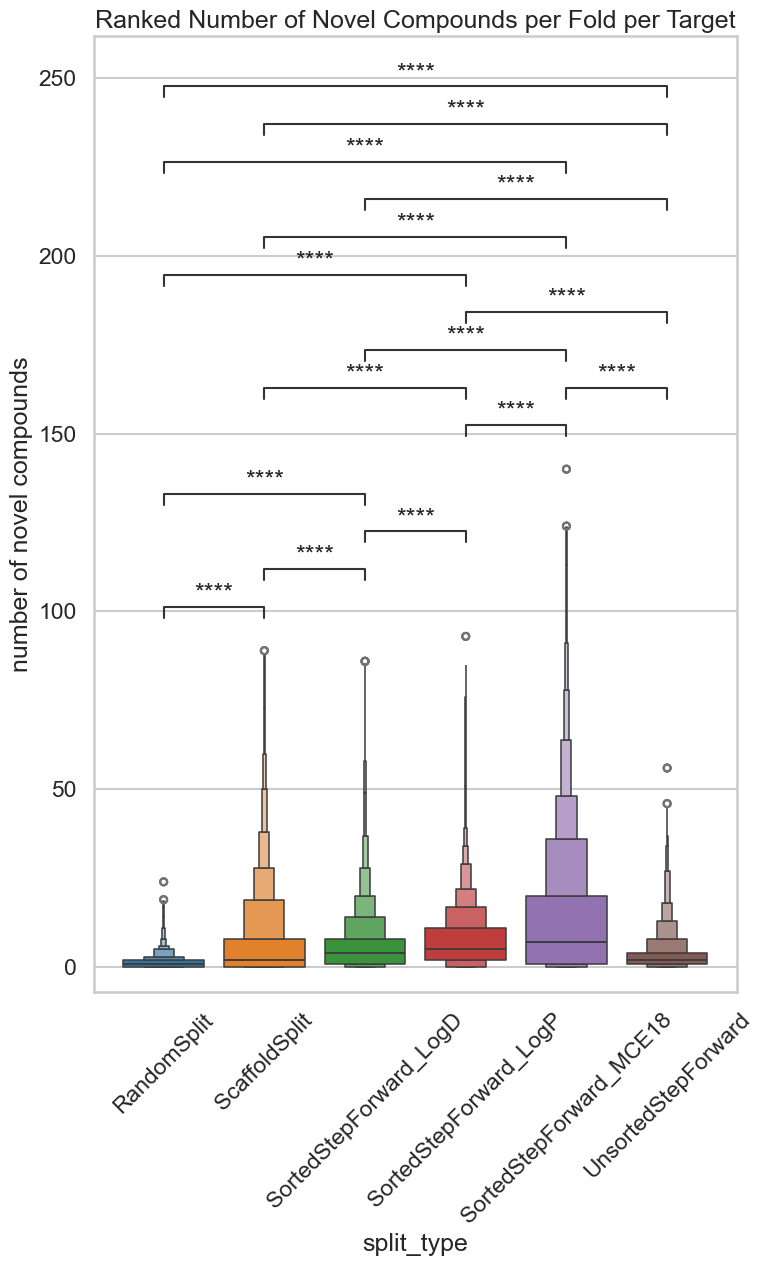

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:1.295e-101 W=2.168e+01
ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:4.125e-29 W=1.123e+01
SortedStepForward_LogD vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:2.620e-09 W=5.959e+00
SortedStepForward_LogP vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:3.353e-40 W=1.333e+01
SortedStepForward_MCE18 vs. UnsortedStepForward: Brunner-Munzel test, P_val:3.058e-251 W=-3.500e+01
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:4.646e-304 W=3.879e+01
ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:1.497e-61 W=1.666e+01
SortedStepForward_LogD vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:1.181e-74 W=1.844e+01
SortedStepForward_LogP vs. UnsortedStepForward: Brunn

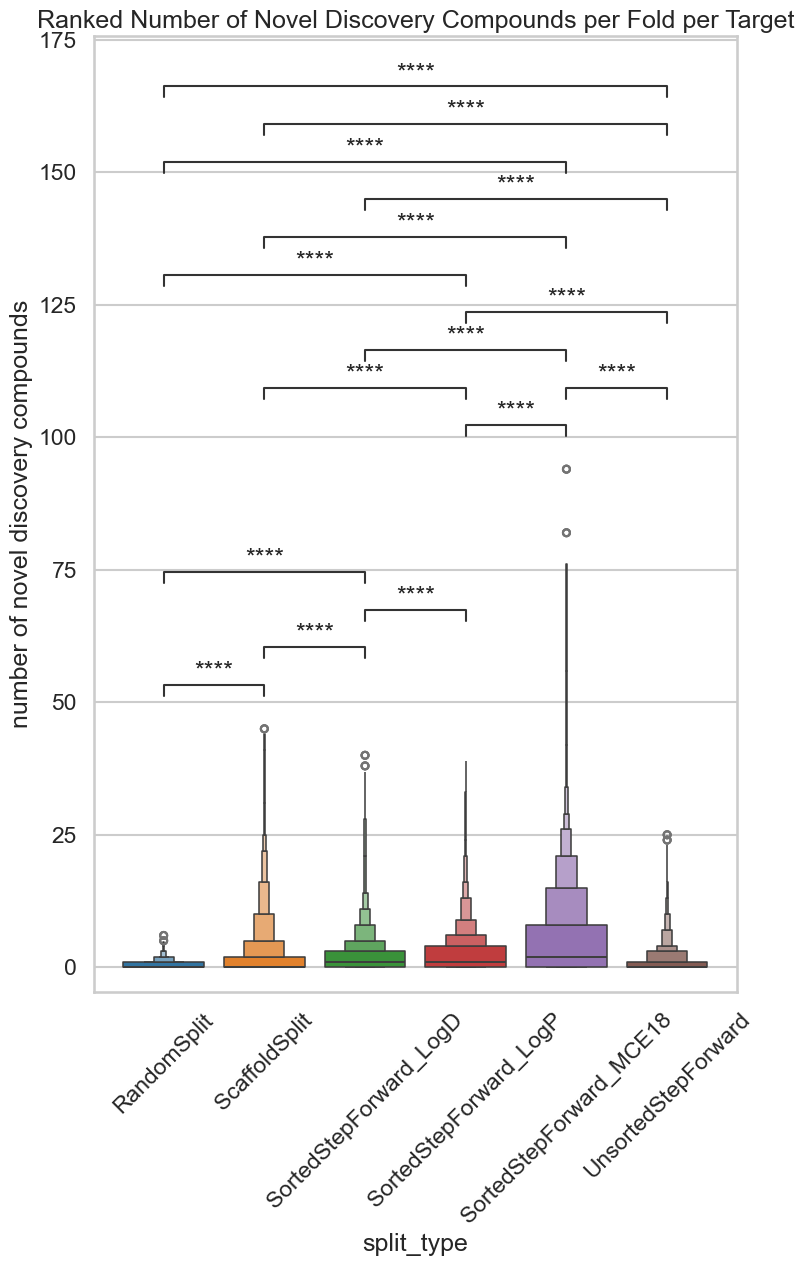

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:4.115e-75 W=1.851e+01
ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:1.411e-10 W=6.421e+00
SortedStepForward_LogD vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:1.575e-04 W=3.780e+00
SortedStepForward_LogP vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:1.135e-20 W=9.342e+00
SortedStepForward_MCE18 vs. UnsortedStepForward: Brunner-Munzel test, P_val:1.878e-119 W=-2.357e+01
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:1.178e-141 W=2.582e+01
ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:2.310e-23 W=9.982e+00
SortedStepForward_LogD vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:8.058e-39 W=1.309e+01
SortedStepForward_LogP vs. UnsortedStepForward: Brunne

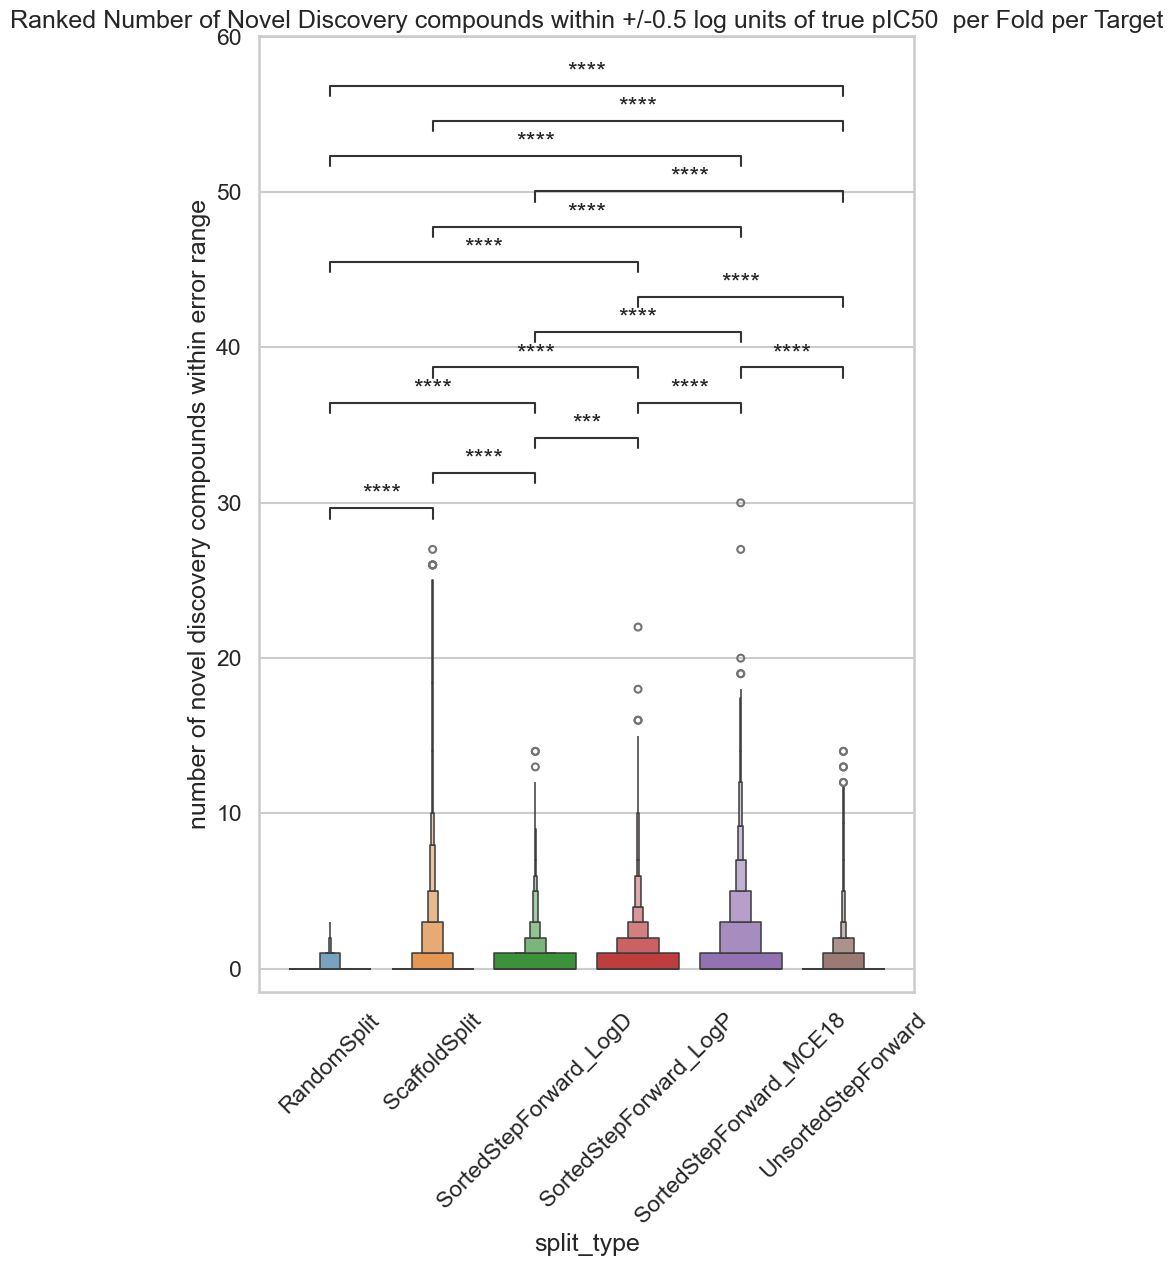

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RandomSplit vs. ScaffoldSplit: Brunner-Munzel test, P_val:1.992e-03 W=3.092e+00
ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:9.939e-08 W=-5.332e+00
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:8.113e-03 W=-2.648e+00
ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:9.939e-08 W=-5.332e+00
RandomSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:8.113e-03 W=-2.648e+00
ScaffoldSplit vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:9.939e-08 W=-5.332e+00
RandomSplit vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:8.113e-03 W=-2.648e+00
ScaffoldSplit vs. UnsortedStepForward: Brunner-Munzel test, P_val:9.939e-08 W=-5.332e+00
RandomSplit vs. UnsortedStepForward: Brunner-Munzel test, P_val:8.113e-03 W=-2.648e+00


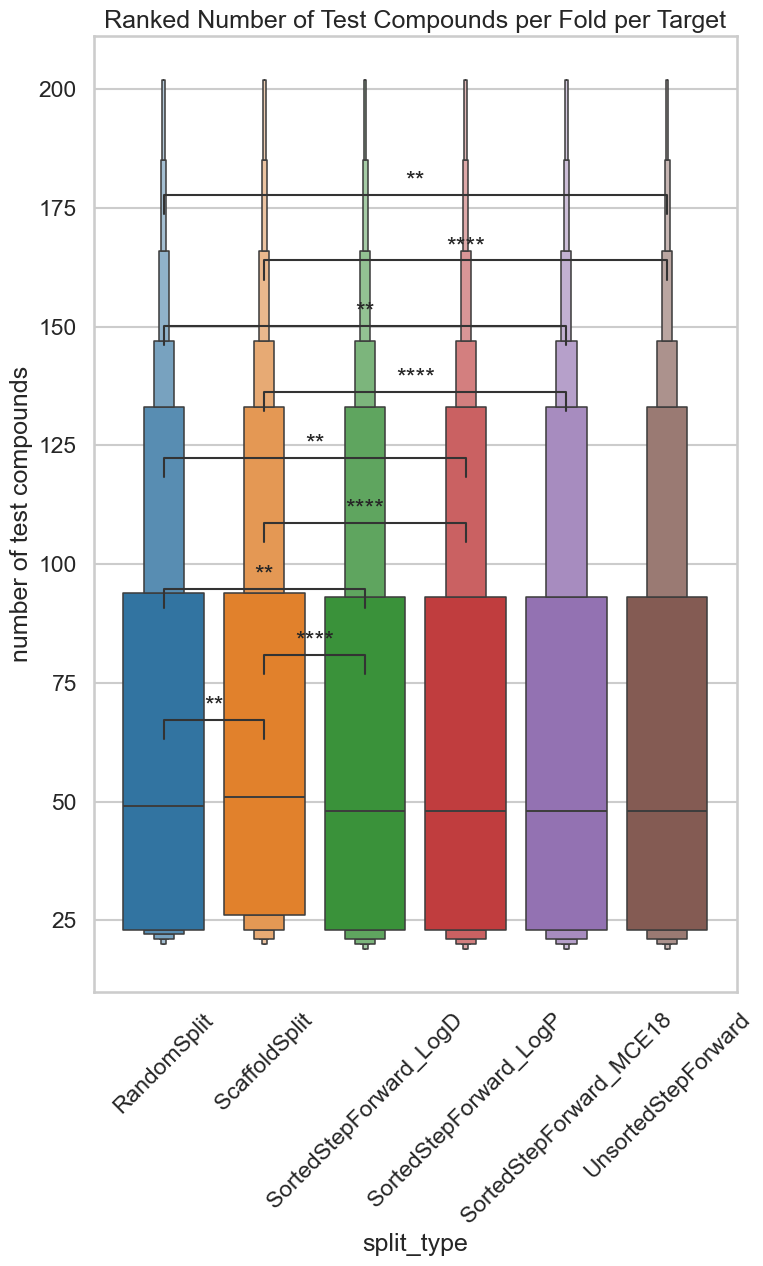

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ScaffoldSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:0.000e+00 W=-4.717e+01
RandomSplit vs. SortedStepForward_LogD: Brunner-Munzel test, P_val:0.000e+00 W=-4.762e+01
ScaffoldSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:0.000e+00 W=-4.717e+01
RandomSplit vs. SortedStepForward_LogP: Brunner-Munzel test, P_val:0.000e+00 W=-4.762e+01
ScaffoldSplit vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:0.000e+00 W=-4.717e+01
RandomSplit vs. SortedStepForward_MCE18: Brunner-Munzel test, P_val:0.000e+00 W=-4.762e+01
ScaffoldSplit vs. UnsortedStepForward: Brunner-Munzel test, P_val:0.000e+00 W=-4.717e+01
RandomSplit vs. UnsortedStepForward: Brunner-Munzel test, P_val:0.000e+00 W=-4.762e+01


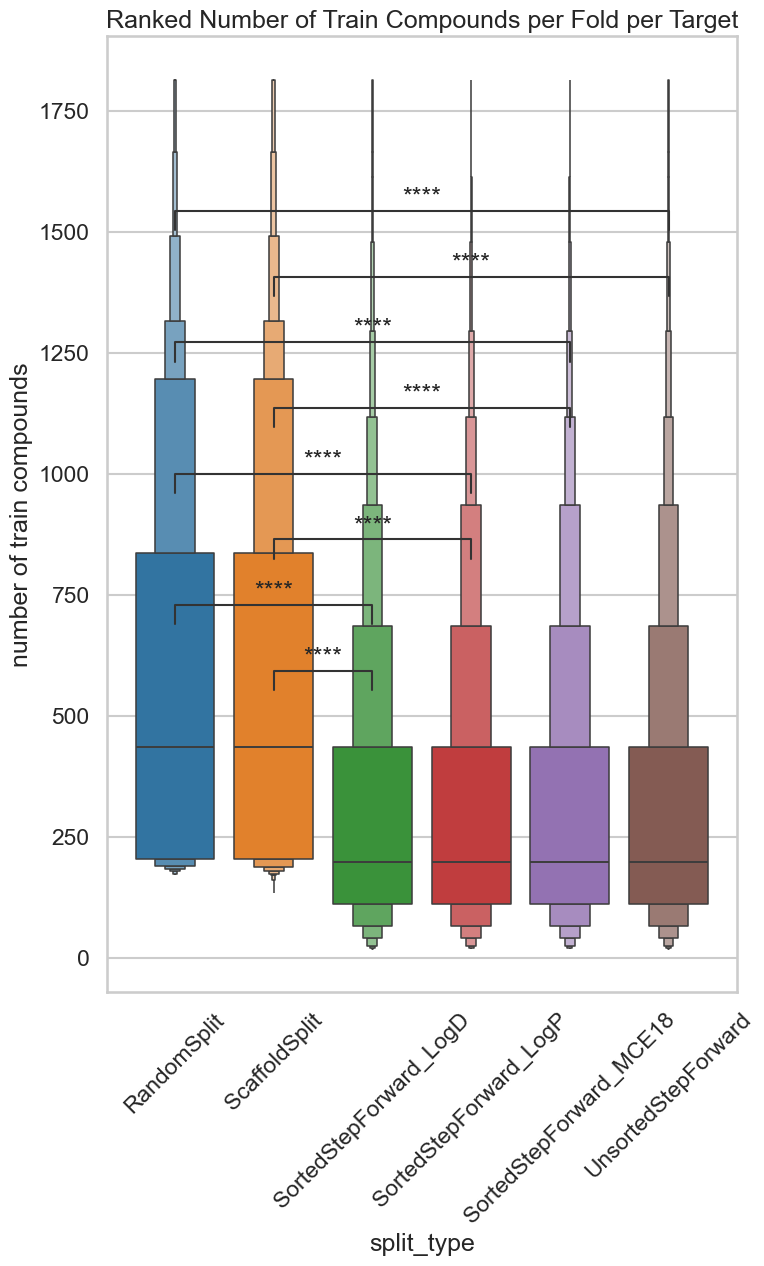

In [43]:
split_types = df["split_type"].unique()
pairs = list(combinations(split_types, 2))  # Generate all pairwise comparisons

for metric in metrics:
    title = metric2title.get(metric, metric)

    plt.figure(figsize=(8, 13))
    ax = sns.boxenplot(data=df, x="split_type", y=metric, hue="split_type", dodge=False)

    # Annotate p-values using statannotations
    annotator = Annotator(ax, pairs, data=df, x="split_type", y=metric)
    annotator.configure(test="Brunner-Munzel", text_format="star", loc="inside",
                        hide_non_significant=True)  # Using independent t-test
    annotator.apply_and_annotate()

    ax.set_title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../benchmark/results/figures/{metric}_Brunner-Munzel.svg')
    plt.show()